In [1]:
from pymongo import MongoClient
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt
import numpy as np
import folium
import math
import gc
import time
from geopy.distance import vincenty
from multiprocessing import Pool

%matplotlib inline  

client = MongoClient(port=27123)
db = client.frevue_data
coll = db.Trips
#cursor = coll.find({"Owner": "United Kingdom, London, UPS"})

# import data and extract list of data owner and the count of data entries for each data owner 

In [2]:
# this section check the number of partners in the database
# choose a partner and check the number of unique vehicles
# then for each vehicle check the number of available days

cursor1 = coll.aggregate([
        {"$group": {"_id": "$Owner", "NumberOfRecords": {"$sum": 1}}}
    ])
array = list(cursor1)
vehlist = pd.DataFrame(array)    #list of operation partners
print vehlist

    NumberOfRecords                                          _id
0               289           Netherlands, Rotterdam, Operator 1
1               305           Netherlands, Rotterdam, Operator 3
2                50           Netherlands, Rotterdam, Operator 2
3               161              United Kingdom, London, Clipper
4              1182  Spain, Madrid, Calidad Pascual & SEUR & TNT
5              1284             Netherlands, Rotterdam, Heineken
6               541             Netherlands, Amsterdam, Heineken
7              5447                  United Kingdom, London, UPS
8              2052                  Netherlands, Rotterdam, UPS
9             12675      Netherlands, Amsterdam & Rotterdam, TNT
10             1589                       Portugal, Lisbon, EMEL
11             1323                        Portugal, Lisbon, CTT
12             4526  Netherlands, Amsterdam & Rotterdam, TNT RAW
13              501                Netherlands, Rotterdam, EMOSS
14               86      

# choose a data owner for analysis

In [3]:
curpartner = vehlist.iloc[0,1]   #current partner can set up a loop  ********************
print "current data owner selected is " + curpartner

current data owner selected is Netherlands, Rotterdam, Operator 1


# Load the data
now extract the number of vehicles (vehicleid) available for the chosen partner and the number of days which data is available for each vehicle

In [4]:
# check valid recordings (distance bigger than 0)
# cursor2 = coll.find(
#         {"$and": [
#                  {"Owner": curpartner},
#                  {"Distance": {"$gt": 0}}
#                 ]
#         })
cursor2 = coll.find(
        {"Owner": curpartner})
PD_Fields = ['TripId', 'Owner', 'VehicleId', 'Frequency', 'Aggregation', 'Distance', 'StateOfChargeStart', 'StateOfChargeEnd', 
            'StateOfChargeMax', 'StateOfChargeMin', 'StateOfChargeUp', 'StateOfChargeDown', 'StartTime', 'EndTime', 'Duration',
            'Extras', 'DataPoints']
PartnerData = pd.DataFrame(list(cursor2), columns=PD_Fields)
PartnerData['sday'] = [x.date() for x in PartnerData['StartTime']]
PartnerData['eday'] = [x.date() for x in PartnerData['EndTime']]
# printing
Veh_num = len(PartnerData['VehicleId'].unique()) #count the number of vehilces
print "Total number of vehicle is " + str(Veh_num) + " from " + curpartner    #number of vehicles

check = sum(PartnerData['sday'] <> PartnerData['eday'])
print "the number of a vehicle with different strip start and end dates is " + str(check)

# check how many days worth of data is availale for each vehicle
# PartnerData['newVID'] = PartnerData['VehicleId'].str[:6] ### ONLY FOR UPS (their data seems to have duplicate vehilces)
# Veh_num2 = len(PartnerData['newVID'].unique())
# print Veh_num2
#veh_days = pd.DataFrame(PartnerData.groupby('newVID').size().rename('numofdays'))
veh_days = pd.DataFrame(PartnerData.groupby('VehicleId').size().rename('numofdays'))
veh_days = veh_days.reset_index(range(veh_days.count()))
veh_days['VID'] = veh_days.index + 1
print "Summary of data availability for each vehicle"
print veh_days


# merge to get unique vehilce ID for each vehicle (for plotting purpose)
#PartnerData = pd.merge(PartnerData, veh_days, left_on = "newVID", right_on = "newVID")
PartnerData = pd.merge(PartnerData, veh_days, left_on = "VehicleId", right_on = "VehicleId")

#tripid should note be used anymore
# PartnerData['TripId'] = pd.to_datetime(PartnerData['TripId'])

Total number of vehicle is 8 from Netherlands, Rotterdam, Operator 1
the number of a vehicle with different strip start and end dates is 5
Summary of data availability for each vehicle
  VehicleId  numofdays  VID
0  14-BGX-9         34    1
1  32-BFJ-6         32    2
2  46-BGX-9         25    3
3  46-BHB-2         33    4
4  47-BGX-9         35    5
5  47-BHB-2         36    6
6  67-BHD-2         34    7
7  95-BHJ-2         60    8


# load the detailed telematics data, extract summary table by day, also compare the GPS distance with Odometer. Then derive acceleration and speed based on speedometer

The basic assumption is that odometer readings are more reliable, along with the speedometer. So with data cleaning:

1. speed above 120km/h
2. speed below zero

In [5]:
def GPS_Processing(vehid):
    vehid = vehid[0]
    print vehid
    vehid_Data = PartnerData[PartnerData['VehicleId'] == vehid].copy()
    # get detailed data
    DetailedData = []
    for daydata in vehid_Data['DataPoints']:
        for datapoint in daydata:
            eachdatapoint = {
                "timestamp": datapoint.get('ts'),
                "lat": datapoint.get('lat'),
                "lon": datapoint.get('lon'),
                "soc": datapoint.get('soc'),
                "vid": vehid,
                "spd": datapoint.get('s'),
            }
            DetailedData.append(eachdatapoint)

    DetailedData = pd.DataFrame(DetailedData).sort_values(by = 'timestamp')
    DetailedData = DetailedData.reset_index(drop=True)
    DetailedData['date'] = [x.date() for x in DetailedData['timestamp']]
    DetailedData['time'] = [x.time() for x in DetailedData['timestamp']]
    
#     print vehid, "before data cleaning - ", DetailedData.shape
    
#     #cleaning: NOTE: Cleaning is postponed.
#     DetailedData = DetailedData[DetailedData['spd']<=120] 
#     DetailedData.set_value(DetailedData['spd']<0, 'spd', 0)
    
#     print vehid, "after data cleaning - ", DetailedData.shape
    
    # this is to add the cumulative distance for each day and instantanious speed for each observation interval
    #starttime = dt.datetime.now()
    Data_adjusted = pd.DataFrame()
    for day in DetailedData['date'].unique():
        current_day_data = DetailedData[DetailedData['date']==day].copy()
        current_day_data.drop_duplicates(subset=['timestamp'],inplace=True)  #some data have dumplicate timestamp. drop them
        current_day_data.sort_values(['timestamp'])
        Distance = [vincenty((current_day_data['lat'].iloc[x], current_day_data['lon'].iloc[x]), (current_day_data['lat'].iloc[x+1], current_day_data['lon'].iloc[x+1])).m for x in range(current_day_data.shape[0]-1)]
        Distance = [0] + Distance
        current_day_data['Distance'] = Distance
        timediff = [(current_day_data['timestamp'].iloc[x+1] - current_day_data['timestamp'].iloc[x]).seconds for x in range(current_day_data.shape[0]-1)]
        timediff = [1] + timediff
        current_day_data['time_diff'] = timediff
        current_day_data['speed'] = current_day_data['Distance']/current_day_data['time_diff']
        current_day_data['cum_dist'] = np.cumsum(Distance)
        current_day_data['spd_mps'] = current_day_data['spd']/3.6 #change to meter/second
        current_day_data['accl_mpss'] = current_day_data.spd_mps.diff()/current_day_data['time_diff'] # calculate accleration - meter per second square
        current_day_data['accl_mpss'].fillna(0, inplace=True) #fill  n/a
        current_day_data['dist_spd'] =  current_day_data['spd_mps'] * current_day_data['time_diff'] # calculate accumulate distance based on speed reading
        current_day_data['cum_dist_spd'] = np.cumsum(current_day_data['dist_spd']) #cumulative distance based on speed reading
        Data_adjusted = Data_adjusted.append(current_day_data)

    #adjust speed; some are too fast - due to errors
#    Data_adjusted=Data_adjusted[Data_adjusted['speed']<50] # not yet
    
    
    # now carry out comparision
    gps_distance = Data_adjusted.groupby(['date']).sum()['Distance']
    vehid_Data['date'] = [x.date() for x in vehid_Data['StartTime']]
    gps_distance = pd.DataFrame(gps_distance)
    gps_distance.reset_index(drop=False,inplace=True)
    
    spd_calc_dist = Data_adjusted.groupby(['date']).sum()['dist_spd'] #distance summary based on speed readings
    spd_calc_dist = pd.DataFrame(spd_calc_dist)
    spd_calc_dist.reset_index(drop=False,inplace=True)
    
    combineddata1 = gps_distance.merge(spd_calc_dist, left_on='date', right_on='date', how='outer')
    combined_data = combineddata1.merge(vehid_Data, left_on='date', right_on='date', how='outer')
    
    combined_distance = combined_data[['date', 'Distance_x', 'Distance_y', 'dist_spd', 'Duration', 'StateOfChargeDown', 'StateOfChargeUp']].copy()
    combined_distance = combined_distance.rename(columns={'Distance_x': 'Distance_GPS'})
    combined_distance = combined_distance.rename(columns={'Distance_y': 'Distance_opr'})
    combined_distance['diff_GPS_Odo'] = combined_distance['Distance_GPS']/combined_distance['Distance_opr']
    combined_distance['diff_spdcalc_Odo'] = combined_distance['dist_spd']/combined_distance['Distance_opr']
    
    #endtime = dt.datetime.now()
    #print endtime-starttime
    combined_distance['Distance_final'] = np.where(combined_distance['Distance_opr']>=combined_distance['Distance_GPS'], combined_distance['Distance_opr'], combined_distance['Distance_GPS'])
    # check the rows with diff bigger than one
    #some data have duplicate days, remove the one with less distance
    combined_distance = combined_distance.sort_values(['Distance_opr'], ascending=False)
    combined_distance.drop_duplicates(subset=['date'], keep='first', inplace=True)
    combined_distance = combined_distance.sort_values(['date'])
    combined_distance['avg_speed'] = combined_distance['Distance_final']/combined_distance['Duration'] * 3.6 # speed based on total distance and duration
    combined_distance['spd_reading'] = [x for x in Data_adjusted.groupby(['date']).mean()['spd']] # speed based on reading
    combined_distance['vid'] = vehid
    
    # results at aggregate level is combined_distance
    return (combined_distance, Data_adjusted)

In [10]:
starttime = dt.datetime.now()

Vehicle_List = [str(x) for x in PartnerData['VehicleId'].unique()]

# cursor2 = coll.distinct("VehicleId", {"$and": [
#                  {"Owner": curpartner},
#                  {"Distance": {"$gt": 0}}
#                 ]
#         })

# Vehicle_List = pd.DataFrame(cursor2, columns=['VehicleId'])

#*****************************************************************************************
# Single-Core Processing
#****************************************************************************************
# Agg_data_all = pd.Series()
# Det_data_all = pd.Series()

# for vid in Vehicle_List['VehicleId']:
#     Agg_data, Det_data = GPS_Processing(vid)
#     Agg_data_all = Agg_data_all.append(Agg_data) 
#     Det_data_all = Det_data_all.append(Det_data)


#**********************************************************************************************
# Multi-core processing
#**********************************************************************************************
Agg_data = pd.Series()
Det_data = pd.Series()
pool1 = Pool(8)
for agg_data_i, Det_data_i in pool1.map(GPS_Processing, np.array_split(Vehicle_List,8)):
    Agg_data = Agg_data.append(agg_data_i)
    Det_data = Det_data.append(Det_data_i)
# Agg_data, Det_data = pool1.map(GPS_Processing, np.array_split(Vehicle_List,8))
pool1.close()
pool1.join()

#reset index
Agg_data.reset_index(drop=True, inplace=True)
Agg_data.drop(labels=[0], inplace=True, axis=1)
Det_data.reset_index(drop=True, inplace=True)
Det_data.drop(labels=[0], inplace=True, axis=1)
#****************************END******************************************************************

#dump file
#Agg_data.to_csv(str(curpartner)+"_Agg.csv")
#Det_data.to_csv(str(curpartner)+"_disaggregate.csv")

endtime = dt.datetime.now()
print endtime-starttime

46-BGX-9
14-BGX-9
95-BHJ-2
32-BFJ-6
47-BGX-9
46-BHB-2
67-BHD-2
47-BHB-2
0:02:45.910649


In [ ]:
# this is suitable for the case with only one vehicle
starttime = dt.datetime.now()

Vehicle_List = [str(x) for x in PartnerData['VehicleId'].unique()]
Agg_data, Det_data = GPS_Processing(Vehicle_List)

#dump file
#Agg_data.to_csv(str(curpartner)+"_Agg.csv")
#Det_data.to_csv(str(curpartner)+"_disaggregate.csv")

So, the summarised data is stored in Agg_data; while the processed telematics data is in Det_data

# first, see the quality of speedometer data

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7


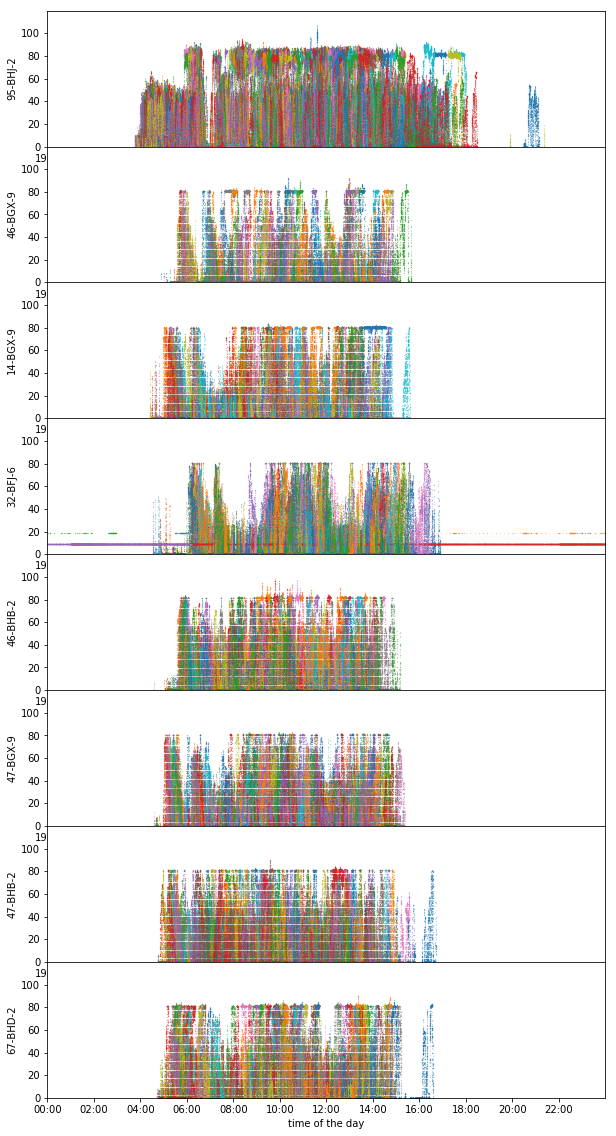

In [7]:
fig5 = pl.figure(figsize=(10, 20))
fig5.subplots_adjust(hspace=0.0)
# pl.subplots_adjust(hspace=0.1)
number_of_subplots=len(Det_data['vid'].unique())

for i,v in enumerate(xrange(number_of_subplots)):
    print i,v
    vehid5 = Det_data['vid'].unique()[i]
    selVehData5 = Det_data[Det_data['vid']==vehid5]
#     datelist = [dt.datetime.strptime(str(x), "%H:%M:%S") for x in seldate['time']]
    datemin = dt.datetime.strptime("1900-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
    datemax = dt.datetime.strptime("1900-01-02 00:00:00", "%Y-%m-%d %H:%M:%S")
    v = v+1
    ax5 = fig5.add_subplot(number_of_subplots,1,v)
    for j in selVehData5['date'].unique():
        seldate = selVehData5[selVehData5['date'] ==j]
        ax5.scatter(mpl.dates.date2num([dt.datetime.strptime(x.strftime("%H:%M:%S"), "%H:%M:%S") for x in seldate['time']]), 
                 seldate['spd'], s=0.01)
    ax5.set_ylabel(vehid5)
    ax5.set_ylim(0, 120)
    ax5.set_yticks(range(0,120,20))
#    ax5.set_ylabel("speed-km/h")
    ax5.set_xlabel("time of the day")
    ax5.set_xlim(datemin,datemax)
    ax5.set_xticks(np.arange(datemin, datemax, (datemax - datemin)/12))

xfmt = mpl.dates.DateFormatter('%H:%M')
ax5.xaxis.set_major_formatter(xfmt)

# now compare GPS speed data

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7


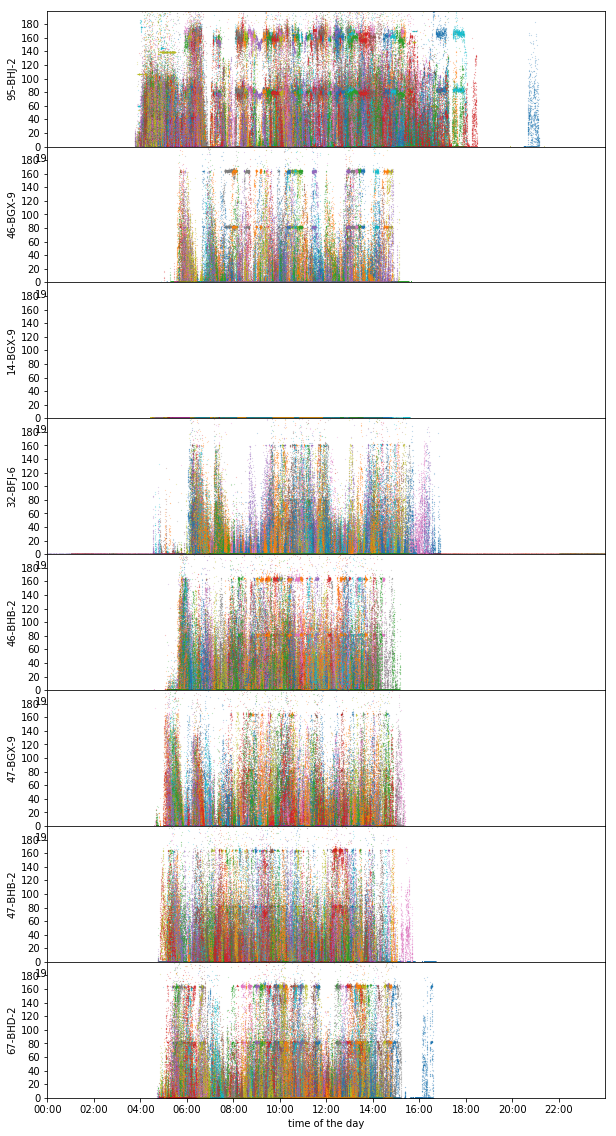

In [8]:
fig5 = pl.figure(figsize=(10, 20))
fig5.subplots_adjust(hspace=0.0)
# pl.subplots_adjust(hspace=0.1)
number_of_subplots=len(Det_data['vid'].unique())

for i,v in enumerate(xrange(number_of_subplots)):
    print i,v
    vehid5 = Det_data['vid'].unique()[i]
    selVehData5 = Det_data[Det_data['vid']==vehid5]
#     datelist = [dt.datetime.strptime(str(x), "%H:%M:%S") for x in seldate['time']]
    datemin = dt.datetime.strptime("1900-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
    datemax = dt.datetime.strptime("1900-01-02 00:00:00", "%Y-%m-%d %H:%M:%S")
    v = v+1
    ax5 = fig5.add_subplot(number_of_subplots,1,v)
    for j in selVehData5['date'].unique():
        seldate = selVehData5[selVehData5['date'] ==j]
        ax5.scatter(mpl.dates.date2num([dt.datetime.strptime(x.strftime("%H:%M:%S"), "%H:%M:%S") for x in seldate['time']]), 
                 seldate['speed']*3.6, s=0.01)
    ax5.set_ylabel(vehid5)
    ax5.set_ylim(0, 200)
    ax5.set_yticks(range(0,200,20))
#    ax5.set_ylabel("speed-km/h")
    ax5.set_xlabel("time of the day")
    ax5.set_xlim(datemin,datemax)
    ax5.set_xticks(np.arange(datemin, datemax, (datemax - datemin)/12))

xfmt = mpl.dates.DateFormatter('%H:%M')
ax5.xaxis.set_major_formatter(xfmt)

# now, clean the telematics data, for speed more than 120kmh, or less than zero
and reproduce the daily summary results

In [11]:
print Det_data.shape

Det_data = Det_data[(Det_data['spd']<=120) & (Det_data['spd']>=0)]
print Det_data.shape


(4829083, 16)
(4822303, 16)


 and generate daily summary results

In [14]:
def daily_summary(Data_adjusted, vehid):
# now carry out comparision
    vehid_Data = PartnerData[PartnerData['VehicleId'] == vehid].copy()
    gps_distance = Data_adjusted.groupby(['date']).sum()['Distance']
    vehid_Data['date'] = [x.date() for x in vehid_Data['StartTime']]
    gps_distance = pd.DataFrame(gps_distance)
    gps_distance.reset_index(drop=False,inplace=True)
    
    spd_calc_dist = Data_adjusted.groupby(['date']).sum()['dist_spd'] #distance summary based on speed readings
    spd_calc_dist = pd.DataFrame(spd_calc_dist)
    spd_calc_dist.reset_index(drop=False,inplace=True)
    
    combineddata1 = gps_distance.merge(spd_calc_dist, left_on='date', right_on='date', how='outer')
    combined_data = combineddata1.merge(vehid_Data, left_on='date', right_on='date', how='outer')
    
    combined_distance = combined_data[['date', 'Distance_x', 'Distance_y', 'dist_spd', 'Duration', 'StateOfChargeDown', 'StateOfChargeUp']].copy()
    combined_distance = combined_distance.rename(columns={'Distance_x': 'Distance_GPS'})
    combined_distance = combined_distance.rename(columns={'Distance_y': 'Distance_opr'})
    combined_distance['diff_GPS_Odo'] = combined_distance['Distance_GPS']/combined_distance['Distance_opr']
    combined_distance['diff_spdcalc_Odo'] = combined_distance['dist_spd']/combined_distance['Distance_opr']
    
    #endtime = dt.datetime.now()
    #print endtime-starttime
    combined_distance['Distance_final'] = np.where(combined_distance['Distance_opr']>=combined_distance['Distance_GPS'], combined_distance['Distance_opr'], combined_distance['Distance_GPS'])
    # check the rows with diff bigger than one
    #some data have duplicate days, remove the one with less distance
    combined_distance = combined_distance.sort_values(['Distance_opr'], ascending=False)
    combined_distance.drop_duplicates(subset=['date'], keep='first', inplace=True)
    combined_distance = combined_distance.sort_values(['date'])
    combined_distance['avg_speed'] = combined_distance['Distance_final']/combined_distance['Duration'] * 3.6 # speed based on total distance and duration
    combined_distance['spd_reading'] = [x for x in Data_adjusted.groupby(['date']).mean()['spd']] # speed based on reading
    combined_distance['vid'] = vehid
    return combined_distance

In [15]:
# reproduce daily summary results
Agg_data = pd.Series()
for i in Det_data['vid'].unique():
    agg_result_i = daily_summary(Det_data[Det_data['vid']==i],i)
    Agg_data = Agg_data.append(agg_result_i)

Agg_data.reset_index(drop=True, inplace=True)
Agg_data.drop(labels=[0], inplace=True, axis=1)

# compare GPS data, Odometer reading; derived distance from speedometer

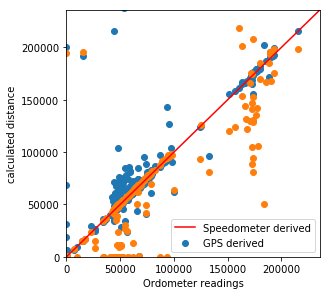

In [17]:
# plotting data availability
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)

ax1.scatter(Agg_data['Distance_opr'], Agg_data['dist_spd'])
ax1.scatter(Agg_data['Distance_opr'], Agg_data['Distance_GPS'])
max_val = int(Agg_data['Distance_opr'].max()*1.1/1000)*1000
ax1.plot( [0,max_val],[0,max_val], 'r')
# ax1.xaxis_date()
# ax1.set_xlim(PartnerData['eday'].min(), PartnerData['eday'].max())
ax1.set_ylim(0, max_val)
ax1.set_xlim(0, max_val)
ax1.set_xlabel('Ordometer readings')
ax1.set_ylabel('derived distance')
ax1.legend(['best fit line','Speedometer derived', 'GPS derived'])

# now, remove the days with zero Odometer readings

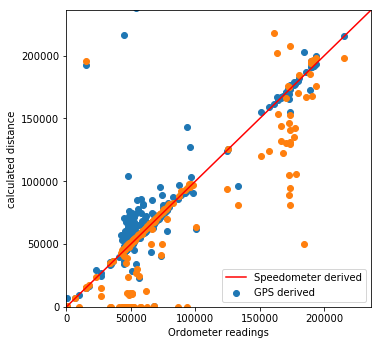

In [18]:
Agg_data = Agg_data[Agg_data['Distance_opr']>0]
# plotting data availability
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)

ax1.scatter(Agg_data['Distance_opr'], Agg_data['dist_spd'])
ax1.scatter(Agg_data['Distance_opr'], Agg_data['Distance_GPS'])
max_val = int(Agg_data['Distance_opr'].max()*1.1/1000)*1000
ax1.plot( [0,max_val],[0,max_val], 'r')
# ax1.xaxis_date()
# ax1.set_xlim(PartnerData['eday'].min(), PartnerData['eday'].max())
ax1.set_ylim(0, max_val)
ax1.set_xlim(0, max_val)
ax1.set_xlabel('Ordometer readings')
ax1.set_ylabel('derived distance')
ax1.legend(['best fit line','Speedometer derived', 'GPS derived'])

# now, plot the data availability

In [30]:
agg_data_table = pd.DataFrame(Agg_data.groupby('vid').size().rename('numofdays'))
agg_data_table['distance'] = Agg_data.groupby('vid').sum()['Distance_opr']/1000
agg_data_table

numofdays  distance
vid                          
14-BGX-9         33  1535.090
32-BFJ-6         30  1377.645
46-BGX-9         24  1134.715
46-BHB-2         32  2086.750
47-BGX-9         35  1702.610
47-BHB-2         36  1889.600
67-BHD-2         34  2073.530
95-BHJ-2         51  8188.930

# and remove the days with difference more than the twice of Odometer readings
NEED TO BE CAREFUL HERE - VALID DATA IS REMOVED

However, this is necessary, even to use average speed model, it is important to remove those errors. see the speed plots above

In [31]:
Agg_data.nlargest(10,'diff_spdcalc_Odo')

Distance_GPS  Distance_final  Distance_opr  Duration  StateOfChargeDown  \
113       0.000000       80.000000          80.0    4260.0                0.0   
44   195593.755322   195593.755322       15395.0   47419.0              -97.6   
137       0.000000    44620.000000       44620.0   63253.0              -57.0   
145   54399.223451    54399.223451       53960.0   58736.0              -64.0   
62    48296.646534    48296.646534       47915.0   22785.0              -27.0   
218   45813.655156    45813.655156       44530.0   29838.0              -35.0   
143   30076.755017    54415.000000       54415.0   31581.0              -61.0   
199    9636.318208    48885.000000       48885.0   30208.0              -55.0   
150   94315.052095    94315.052095       93380.0   29208.0              -87.0   
192   58971.688327    58971.688327       57875.0   34207.0              -58.0   

     StateOfChargeUp  avg_speed        date  diff_GPS_Odo  diff_spdcalc_Odo  \
113              0.0   0.067606  2016-11-11      0.000000         86.881944   
44               7.6  14.849270  2016-10-20     12.705018         12.482485   
137             20.0   2.539516  2016-10-30      0.000000          4.843686   
145             65.0   3.334194  2016-11-10      1.008140          4.407346   
62               0.0   7.630807  2016-10-05      1.007965          2.167003   
218              5.0   5.527487  2016-09-22      1.028827          1.594256   
143             12.0   6.202907  2016-11-08      0.552729          1.555579   
199             15.0   5.825808  2016-10-21      0.197122          1.553391   
150             18.0  11.624698  2016-09-22      1.010013          1.531776   
192             13.0   6.206276  2016-10-12      1.018949          1.488956   

          dist_spd  spd_reading       vid  
113    6950.555556     1.827586  14-BGX-9  
44   192167.861111    31.477070  95-BHJ-2  
137  216125.283889     9.398000  32-BFJ-6  
145  237820.410278    11.638732  32-BFJ-6  
62   103831.944444    67.811881  46-BGX-9  
218   70992.222222    17.931284  47-BHB-2  
143   84646.856667     7.080591  32-BFJ-6  
199   75937.500000    16.622298  47-BGX-9  
150  143037.222222    19.142941  46-BHB-2  
192   86173.333333    18.065778  47-BGX-9

In [32]:
print Agg_data.shape
Agg_data = Agg_data[Agg_data['diff_spdcalc_Odo']<2]
print Agg_data.shape

(275, 13)
(270, 13)


In [33]:
# summarise again
agg_data_table = pd.DataFrame(Agg_data.groupby('vid').size().rename('numofdays'))
agg_data_table['distance'] = Agg_data.groupby('vid').sum()['Distance_opr']/1000
agg_data_table

numofdays  distance
vid                          
14-BGX-9         32  1535.010
32-BFJ-6         28  1279.065
46-BGX-9         23  1086.800
46-BHB-2         32  2086.750
47-BGX-9         35  1702.610
47-BHB-2         36  1889.600
67-BHD-2         34  2073.530
95-BHJ-2         50  8173.535

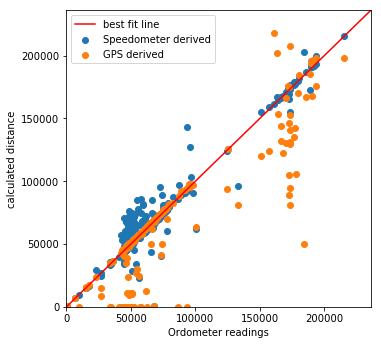

In [35]:
# plotting data availability
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)

ax1.scatter(Agg_data['Distance_opr'], Agg_data['dist_spd'])
ax1.scatter(Agg_data['Distance_opr'], Agg_data['Distance_GPS'])
max_val = int(Agg_data['Distance_opr'].max()*1.1/1000)*1000
ax1.plot( [0,max_val],[0,max_val], 'r')
# ax1.xaxis_date()
# ax1.set_xlim(PartnerData['eday'].min(), PartnerData['eday'].max())
ax1.set_ylim(0, max_val)
ax1.set_xlim(0, max_val)
ax1.set_xlabel('Ordometer readings')
ax1.set_ylabel('derived distance')
ax1.legend(['best fit line','Speedometer derived', 'GPS derived'])

this figure is the results after data cleaning

# now, regenerate the processed telematics data - based on cleaned summary data

In [45]:
# reproduce the telematics data
print Det_data.shape

Det_data_results = pd.Series()
for v_id in Agg_data['vid'].unique():
    print v_id
    data_vid = Det_data[Det_data['vid']==v_id]
    data_vid_date = data_vid[data_vid['date'].isin(Agg_data[Agg_data['vid']==v_id]['date'].unique())]
    Det_data_results = Det_data_results.append(data_vid_date)
    
Det_data_results.reset_index(drop=True, inplace=True)
Det_data_results.drop(labels=[0], inplace=True, axis=1)

print Det_data_results.shape

(4822303, 16)
95-BHJ-2
46-BGX-9
14-BGX-9
32-BFJ-6
46-BHB-2
47-BGX-9
47-BHB-2
67-BHD-2
(4609602, 16)


0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7


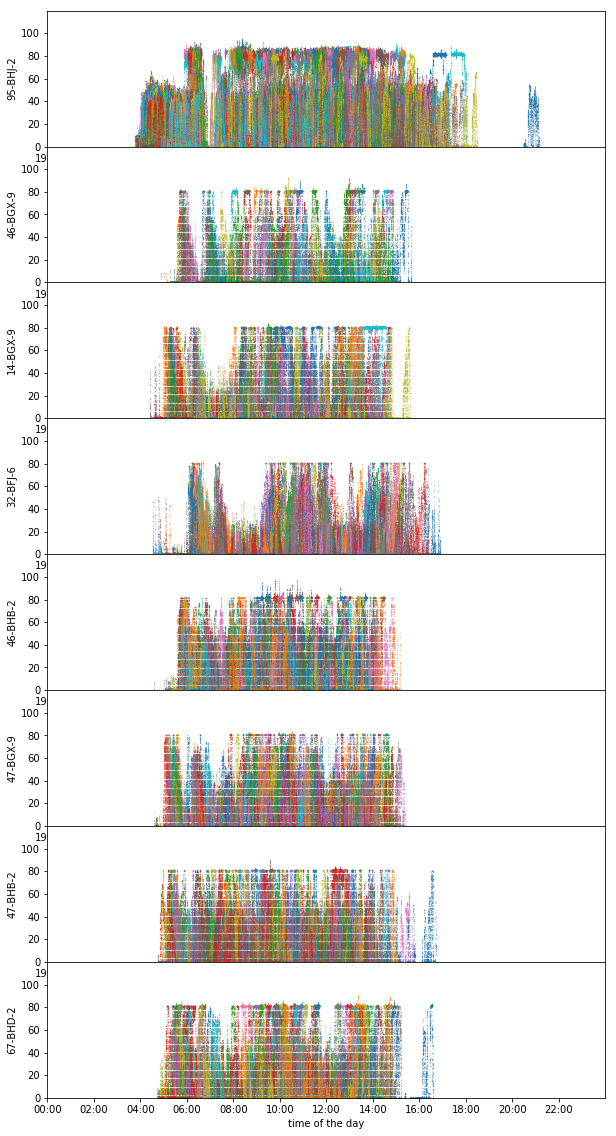

In [47]:
# check speed profiles again:
fig5 = pl.figure(figsize=(10, 20))
fig5.subplots_adjust(hspace=0.0)
# pl.subplots_adjust(hspace=0.1)
number_of_subplots=len(Det_data['vid'].unique())

for i,v in enumerate(xrange(number_of_subplots)):
    print i,v
    vehid5 = Det_data_results['vid'].unique()[i]
    selVehData5 = Det_data_results[Det_data_results['vid']==vehid5]
#     datelist = [dt.datetime.strptime(str(x), "%H:%M:%S") for x in seldate['time']]
    datemin = dt.datetime.strptime("1900-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
    datemax = dt.datetime.strptime("1900-01-02 00:00:00", "%Y-%m-%d %H:%M:%S")
    v = v+1
    ax5 = fig5.add_subplot(number_of_subplots,1,v)
    for j in selVehData5['date'].unique():
        seldate = selVehData5[selVehData5['date'] ==j]
        ax5.scatter(mpl.dates.date2num([dt.datetime.strptime(x.strftime("%H:%M:%S"), "%H:%M:%S") for x in seldate['time']]), 
                 seldate['spd'], s=0.01)
    ax5.set_ylabel(vehid5)
    ax5.set_ylim(0, 120)
    ax5.set_yticks(range(0,120,20))
#    ax5.set_ylabel("speed-km/h")
    ax5.set_xlabel("time of the day")
    ax5.set_xlim(datemin,datemax)
    ax5.set_xticks(np.arange(datemin, datemax, (datemax - datemin)/12))

xfmt = mpl.dates.DateFormatter('%H:%M')
ax5.xaxis.set_major_formatter(xfmt)

# Plotting of data availability 

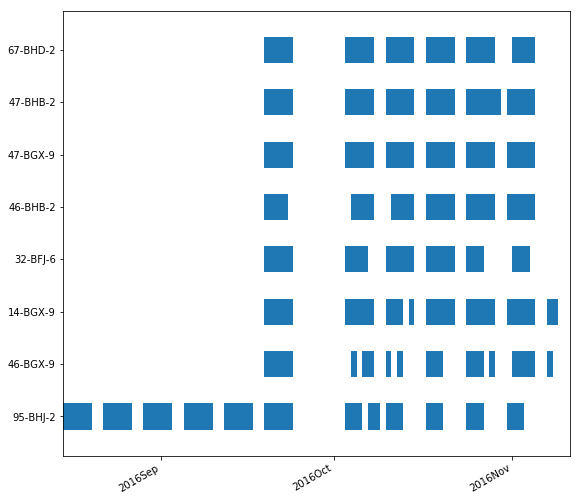

In [57]:
# plotting data availability
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')
monthsFmt = mdates.DateFormatter('%Y%b')

fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(2,2,1)
vehlist = []
curID = 0
for i in Agg_data['vid'].unique():
    datelist = []
    selVehData = Agg_data[Agg_data['vid']==i]
    curID +=1
    sdate = selVehData['date'].min()
    edate = selVehData['date'].max()
    diffdate = edate - sdate
    dateswitch = 0
    curdate = sdate
    for j in range(0, int(diffdate.days)):
        predate = curdate                          #previous date
        curdate = curdate + dt.timedelta(days=1)     #current date
        if any(selVehData['date'] == curdate) and dateswitch == 1:
            sdate = curdate
            dateswitch = 0
        if (not any(selVehData['date'] == curdate)) and dateswitch == 0:   #if current date is not available, call plotting
            #pltmain(sdate, predate)
            datelist.append((mpl.dates.date2num(sdate), mpl.dates.date2num(curdate)-mpl.dates.date2num(sdate)))
            dateswitch = 1
    ax1.broken_barh(datelist, (curID,0.5))
    vehlist.append(i)
ax1.xaxis_date()
ax1.set_xlim(Agg_data['date'].min(), Agg_data['date'].max())
ax1.set_ylim(0.5, len(Agg_data['vid'].unique())+1)
ax1.yaxis.set_ticks(np.arange(1.25, len(Agg_data['vid'].unique())+1))
ax1.set_yticklabels(vehlist)
#ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_locator(months)
#ax1.xaxis.set_major_formatter(yearsFmt)
ax1.xaxis.set_major_formatter(monthsFmt)
#ax1.xaxis.set_minor_locator(months)
fig.autofmt_xdate()

# plotting of total distance per day

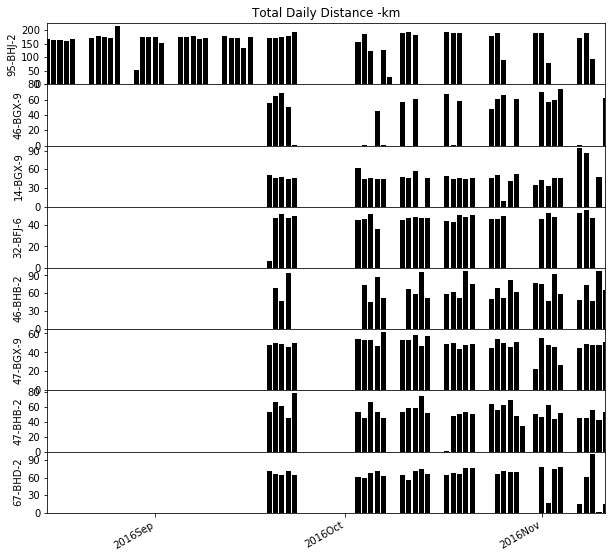

In [62]:
fig2 = pl.figure(figsize=(10, 10))
fig2.subplots_adjust(hspace=0.0)
# pl.subplots_adjust(hspace=0.1)
number_of_subplots=len(Agg_data['vid'].unique())

for i,v in enumerate(xrange(number_of_subplots)):
    vehid = Agg_data['vid'].unique()[i]
    selVehData2 = Agg_data[Agg_data['vid']==vehid]

    sdate2 = selVehData2['date'].min()
    edate2 = selVehData2['date'].max()

    delta2 = edate2-sdate2
    
    v = v+1
    ax2 = fig2.add_subplot(number_of_subplots,1,v)
    ax2.bar(mpl.dates.date2num(selVehData2['date']), selVehData2['Distance_opr']/1000, color='black')

    ax2.xaxis_date()
    ax2.set_xlim(Agg_data['date'].min(), Agg_data['date'].max())
    ax2.set_ylabel(vehid)
    if i == 0:
        ax2.set_title("Total Daily Distance -km")
    maxdis = max(selVehData2['Distance_opr']/1000)
    ax2.set_yticks(range(0,int(maxdis*1.1), int(math.ceil((maxdis*1.1/5)/10)*10)))

#ax2.xaxis.set_major_locator(years)
ax2.xaxis.set_major_locator(months)
#ax2.xaxis.set_major_formatter(yearsFmt)
ax2.xaxis.set_major_formatter(monthsFmt)
#ax2.xaxis.set_minor_locator(months)    

fig2.autofmt_xdate()


# speed profiles

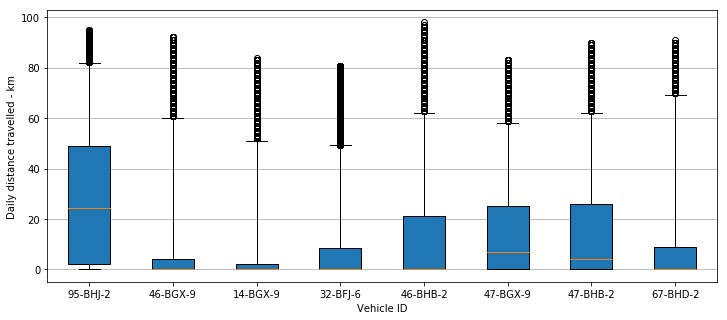

In [64]:
# box plot for distance statistics

fig3 = plt.figure(figsize=(12, 5))
ax3 = fig3.add_subplot(1,1,1)
# # Random test data
# np.random.seed(123)
# all_data = [np.random.normal(0, std, 100) for std in range(1, 4)]

lsdata = []
lsveh = []
boxplotdata = []
for i in Det_data_results['vid'].unique():
    lsveh.append(i)
    currdata = np.array(Det_data_results[Det_data_results['vid']==i]['spd'])
    boxplotdata.append(currdata)

boxplotdata = np.array(boxplotdata)
# boxplotdata['VehicleId'] = PartnerData['VehicleId']

# rectangular box plot
ax3.boxplot(boxplotdata,
            vert=True,   # vertical box aligmnent
            patch_artist=True, 
            whis=[5, 95])


# adding horizontal grid lines
ax3.yaxis.grid(True)
ax3.set_xticks([y+1 for y in range(len(Det_data_results['vid'].unique()))], )
ax3.set_xlabel('Vehicle ID')
ax3.set_ylabel('Daily distance travelled - km')

# add x-tick labels
plt.setp(ax3, xticks=[y+1 for y in range(len(Det_data_results['vid'].unique()))],
         xticklabels=lsveh)

# plt.show()

# some statistics of daily distance for each of the vehicle

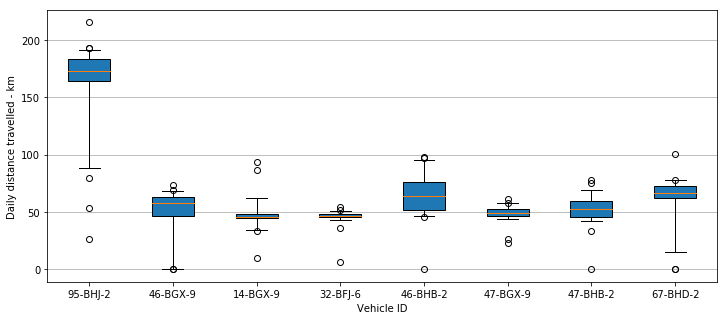

In [65]:
# box plot for distance statistics

fig3 = plt.figure(figsize=(12, 5))
ax3 = fig3.add_subplot(1,1,1)
# # Random test data
# np.random.seed(123)
# all_data = [np.random.normal(0, std, 100) for std in range(1, 4)]

lsdata = []
lsveh = []
boxplotdata = []
for i in Agg_data['vid'].unique():
    lsveh.append(i)
    currdata = np.array(Agg_data[Agg_data['vid']==i]['Distance_opr']/1000)
    boxplotdata.append(currdata)

boxplotdata = np.array(boxplotdata)
# boxplotdata['VehicleId'] = PartnerData['VehicleId']

# rectangular box plot
ax3.boxplot(boxplotdata,
            vert=True,   # vertical box aligmnent
            patch_artist=True, 
            whis=[5, 95])


# adding horizontal grid lines
ax3.yaxis.grid(True)
ax3.set_xticks([y+1 for y in range(len(Agg_data['vid'].unique()))], )
ax3.set_xlabel('Vehicle ID')
ax3.set_ylabel('Daily distance travelled - km')

# add x-tick labels
plt.setp(ax3, xticks=[y+1 for y in range(len(Agg_data['vid'].unique()))],
         xticklabels=lsveh)

# plt.show()

# plotting of the state of charge status over the periods

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7


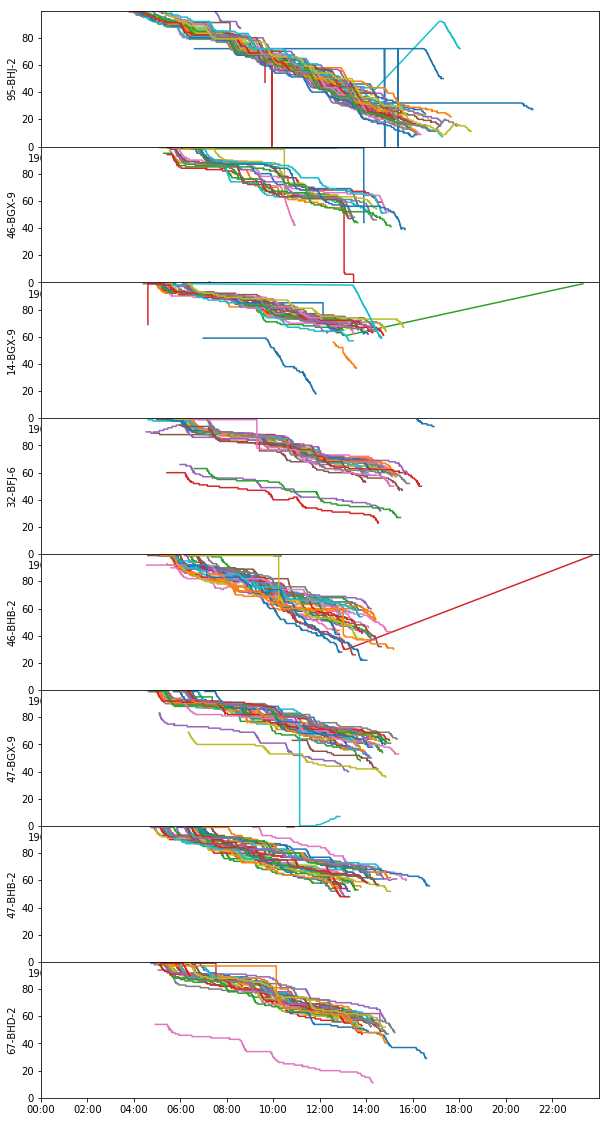

In [69]:
fig5 = pl.figure(figsize=(10, 20))
fig5.subplots_adjust(hspace=0.0)
# pl.subplots_adjust(hspace=0.1)
number_of_subplots=len(Agg_data['vid'].unique())

for i,v in enumerate(xrange(number_of_subplots)):
    print i,v
    vehid5 = Agg_data['vid'].unique()[i]
    selVehData5 = Det_data_results[Det_data_results['vid']==vehid5]
#     datelist = [dt.datetime.strptime(str(x), "%H:%M:%S") for x in seldate['time']]
    datemin = dt.datetime.strptime("1900-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
    datemax = dt.datetime.strptime("1900-01-02 00:00:00", "%Y-%m-%d %H:%M:%S")
    v = v+1
    ax5 = fig5.add_subplot(number_of_subplots,1,v)
    for j in selVehData5['date'].unique():
        seldate = selVehData5[selVehData5['date'] ==j]
        ax5.plot(mpl.dates.date2num([dt.datetime.strptime(x.strftime("%H:%M:%S"), "%H:%M:%S") for x in seldate['time']]), 
                 seldate['soc'])
    ax5.set_ylabel(vehid5)
    ax5.set_ylim(0, 100)
    ax5.set_yticks(range(0,100,20))
    ax5.set_xlim(datemin,datemax)
    ax5.set_xticks(np.arange(datemin, datemax, (datemax - datemin)/12))

xfmt = mpl.dates.DateFormatter('%H:%M')
ax5.xaxis.set_major_formatter(xfmt)

# fig5.autofmt_xdate()

# GPS locations plot - too slow!!!

In [ ]:
# plotting
clusteredmap_nn = folium.Map(location=[51.5, -0.14],
                          zoom_start=10)
for name, row in coordinates.iterrows():
#for name, row in cho_LTDS[cho_LTDS['topurp']==18].iterrows():
#    folium.Marker([row["lat"], row["lon"]]).add_to(map_geotweet)
    folium.CircleMarker([row["lat"], row["lon"]],radius=2,color='red',fill_color='red').add_to(clusteredmap_nn)
# folium.CircleMarker([row["lat"], row["lon"]],radius=row["pointcounts"],color='red',fill_color='red', popup=str(row["pointcounts"])).add_to(clusteredmap)
# folium.Marker[]

clusteredmap_nn

In [76]:
#using markercluster

clusteredmap_nn = folium.Map(location=[51.5, -0.14], zoom_start=10)

marker_cluster = folium.MarkerCluster().add_to(clusteredmap_nn)

v_id = Agg_data['vid'].unique()[0]

coordinates = Det_data_results[Det_data_results['vid']==v_id]
print coordinates.shape
for name, row in coordinates.iterrows():
    print name
    folium.Marker(
        location=[row["lat"], row["lon"]],
#        popup='Add popup text here.',
        icon=folium.Icon(color='green', icon='fa-circle'), #fontawesome
    ).add_to(marker_cluster)


#m.save(os.path.join('results', 'MarkerCluster_simple.html'))

clusteredmap_nn



(940451, 16)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
2

KeyboardInterrupt: 

# dump results

In [146]:
# dump file -aggregate results
Agg_data.to_csv("./results/" + str(curpartner)+"_Agg.csv")

results for the telematics data is a bit problematic - frequency - 2HZ; 

In [147]:
# dump telematics data by vehicle ids
for i in Det_data_results['vid'].unique():
    aa = Det_data_results[Det_data_results['vid']==i]
    aa.to_csv(str(curpartner)+"_" + i + "_data.csv")

In [94]:
# v_id_data = Det_data_results[Det_data_results['vid']==v_id].copy(deep=True)
# v_id_data.set_index('timestamp', drop=True, inplace=True)
# bfill_vid = v_id_data.resample('500L').bfill()
# ffill_vid = v_id_data.resample('500L').pad()

# check the GPS distance - which one is accurate

In [30]:
# use Netherlands, Rotterdam, Operator 1; 95-BHJ-2; 2016-08-26 as an example
# data error: check 2016-08-29; 95-BHJ-2
# distance record error: check 2016-10-21;  95-BHJ-2
print PartnerData['Extras'][0]['DistanceGps']['_v']
print PartnerData['Distance'][0]
cursor3 = coll.find(
    {"$and": [{"Owner": "Netherlands, Rotterdam, Operator 1"},
              {"VehicleId": "95-BHJ-2"}, {"TripId": "2016-08-29"}]}, 
    {"DataPoints":1, "_id": 0})
aa = list(cursor3)
lat = [bb['lat'] for bb in aa[0]['DataPoints']]
lon = [bb['lon'] for bb in aa[0]['DataPoints']]
coordinates = pd.DataFrame(zip(lat, lon), columns=['lat', 'lon'])
coordinates.lat = coordinates.lat.astype('float')
coordinates.lon = coordinates.lon.astype('float')
Distance = [vincenty((coordinates['lat'][x], coordinates['lon'][x]), (coordinates['lat'][x+1], coordinates['lon'][x+1])).m for x in range(coordinates.shape[0]-1)]
print sum(Distance)

87556.7654767
166730.0
330070.865188


In [31]:
# plotting
clusteredmap_nn = folium.Map(location=[51.5, -0.14],
                          zoom_start=10)
for name, row in coordinates.iterrows():
#for name, row in cho_LTDS[cho_LTDS['topurp']==18].iterrows():
#    folium.Marker([row["lat"], row["lon"]]).add_to(map_geotweet)
    folium.CircleMarker([row["lat"], row["lon"]],radius=2,color='red',fill_color='red').add_to(clusteredmap_nn)
# folium.CircleMarker([row["lat"], row["lon"]],radius=row["pointcounts"],color='red',fill_color='red', popup=str(row["pointcounts"])).add_to(clusteredmap)
# folium.Marker[]

clusteredmap_nn

# a combined process of cleaning and processing GPS data, also generating aggregate data. note the quality of GPS data varies, and distance from operator should be used to avoid missing milages

In [5]:
def GPS_Processing(vehid):
    vehid = vehid[0]
    print vehid
    # use '95-BHJ-2' as an example
    #vehid = '95-BHJ-2'
#     cursor3 = coll.find(
#         {"$and": [{"Owner": curpartner},
#                   {"VehicleId": vehid}]})
#     vehid_Fields = ['TripId', 'Owner', 'VehicleId', 'Frequency', 'Aggregation', 'Distance', 'StateOfChargeStart', 'StateOfChargeEnd', 
#                 'StateOfChargeMax', 'StateOfChargeMin', 'StateOfChargeUp', 'StateOfChargeDown', 'StartTime', 'EndTime', 'Duration',
#                 'Extras', 'DataPoints']
#     vehid_Data = pd.DataFrame(list(cursor3), columns=vehid_Fields)
    vehid_Data = PartnerData[PartnerData['VehicleId'] == vehid].copy()
    # get detailed data
    DetailedData = []
    for daydata in vehid_Data['DataPoints']:
        for datapoint in daydata:
            eachdatapoint = {
                "timestamp": datapoint.get('ts'),
                "lat": datapoint.get('lat'),
                "lon": datapoint.get('lon'),
        #        "alt": datapoint.get('alt'),
        #        "speed": datapoint.get('s'),
                "soc": datapoint.get('soc'),
                "vid": vehid,
                "spd": datapoint.get('s'),
        #        "range": datapoint.get('r'),
        #        "batterytemp": datapoint.get('tb'),
        #        "cabtemp": datapoint.get('ti'),
        #        "outsidetemp": datapoint.get('to'),
        #        "throttle": datapoint.get('thr'),
        #        "ignition": datapoint.get('i'),
        #        'VehID': veh_id
            }
            DetailedData.append(eachdatapoint)

    DetailedData = pd.DataFrame(DetailedData).sort_values(by = 'timestamp')
    DetailedData = DetailedData.reset_index(drop=True)
    DetailedData['date'] = [x.date() for x in DetailedData['timestamp']]
    DetailedData['time'] = [x.time() for x in DetailedData['timestamp']]
    
    #cleaning
    DetailedData = DetailedData[DetailedData['spd']<=120] 
    DetailedData.set_value(DetailedData['spd']<0, 'spd', 0)
    
    # this is to add the cumulative distance for each day and instantanious speed for each observation interval
    #starttime = dt.datetime.now()
    Data_adjusted = pd.DataFrame()
    for day in DetailedData['date'].unique():
        current_day_data = DetailedData[DetailedData['date']==day].copy()
        current_day_data.drop_duplicates(subset=['timestamp'],inplace=True)  #some data have dumplicate timestamp. drop them
        current_day_data.sort_values(['timestamp'])
        Distance = [vincenty((current_day_data['lat'].iloc[x], current_day_data['lon'].iloc[x]), (current_day_data['lat'].iloc[x+1], current_day_data['lon'].iloc[x+1])).m for x in range(current_day_data.shape[0]-1)]
        Distance = [0] + Distance
        current_day_data['Distance'] = Distance
        timediff = [(current_day_data['timestamp'].iloc[x+1] - current_day_data['timestamp'].iloc[x]).seconds for x in range(current_day_data.shape[0]-1)]
        timediff = [1] + timediff
        current_day_data['time_diff'] = timediff
        current_day_data['speed'] = current_day_data['Distance']/current_day_data['time_diff']
        current_day_data['cum_dist'] = np.cumsum(Distance)
        current_day_data['spd_mps'] = current_day_data['spd']/3.6 #change to meter/second
        current_day_data['accl_mpss'] = current_day_data.spd_mps.diff()/current_day_data['time_diff'] # calculate accleration - meter per second square
        current_day_data['accl_mpss'].fillna(0, inplace=True) #fill  n/a
        current_day_data['dist_spd'] =  current_day_data['spd_mps'] * current_day_data['time_diff'] # calculate accumulate distance based on speed reading
        current_day_data['cum_dist_spd'] = np.cumsum(current_day_data['dist_spd']) #cumulative distance based on speed reading
        Data_adjusted = Data_adjusted.append(current_day_data)

    #adjust speed; some are too fast - due to errors
#    Data_adjusted=Data_adjusted[Data_adjusted['speed']<50] # not yet
    
    
    # now carry out comparision
    gps_distance = Data_adjusted.groupby(['date']).sum()['Distance']
    vehid_Data['date'] = [x.date() for x in vehid_Data['StartTime']]
    gps_distance = pd.DataFrame(gps_distance)
    gps_distance.reset_index(drop=False,inplace=True)
    
    spd_calc_dist = Data_adjusted.groupby(['date']).sum()['dist_spd'] #distance summary based on speed readings
    spd_calc_dist = pd.DataFrame(spd_calc_dist)
    spd_calc_dist.reset_index(drop=False,inplace=True)
    
    combineddata1 = gps_distance.merge(spd_calc_dist, left_on='date', right_on='date', how='outer')
    combined_data = combineddata1.merge(vehid_Data, left_on='date', right_on='date', how='outer')
    
    combined_distance = combined_data[['date', 'Distance_x', 'Distance_y', 'dist_spd', 'Duration', 'StateOfChargeDown', 'StateOfChargeUp']].copy()
    combined_distance = combined_distance.rename(columns={'Distance_x': 'Distance_GPS'})
    combined_distance = combined_distance.rename(columns={'Distance_y': 'Distance_opr'})
    combined_distance['diff_GPS_Odo'] = combined_distance['Distance_GPS']/combined_distance['Distance_opr']
    combined_distance['diff_spdcalc_Odo'] = combined_distance['dist_spd']/combined_distance['Distance_opr']
    
    #endtime = dt.datetime.now()
    #print endtime-starttime
    combined_distance['Distance_final'] = np.where(combined_distance['Distance_opr']>=combined_distance['Distance_GPS'], combined_distance['Distance_opr'], combined_distance['Distance_GPS'])
    # check the rows with diff bigger than one
    #some data have duplicate days, remove the one with less distance
    combined_distance = combined_distance.sort_values(['Distance_opr'], ascending=False)
    combined_distance.drop_duplicates(subset=['date'], keep='first', inplace=True)
    combined_distance = combined_distance.sort_values(['date'])
    combined_distance['avg_speed'] = combined_distance['Distance_final']/combined_distance['Duration'] * 3.6 # speed based on total distance and duration
    combined_distance['spd_reading'] = [x for x in Data_adjusted.groupby(['date']).mean()['spd']] # speed based on reading
    combined_distance['vid'] = vehid
    
    # results at aggregate level is combined_distance
    return (combined_distance, Data_adjusted)

In [6]:
starttime = dt.datetime.now()

Vehicle_List = [str(x) for x in PartnerData['VehicleId'].unique()]

# cursor2 = coll.distinct("VehicleId", {"$and": [
#                  {"Owner": curpartner},
#                  {"Distance": {"$gt": 0}}
#                 ]
#         })

# Vehicle_List = pd.DataFrame(cursor2, columns=['VehicleId'])

#*****************************************************************************************
# Single-Core Processing
#****************************************************************************************
# Agg_data_all = pd.Series()
# Det_data_all = pd.Series()

# for vid in Vehicle_List['VehicleId']:
#     Agg_data, Det_data = GPS_Processing(vid)
#     Agg_data_all = Agg_data_all.append(Agg_data) 
#     Det_data_all = Det_data_all.append(Det_data)


#**********************************************************************************************
# Multi-core processing
#**********************************************************************************************
Agg_data = pd.Series()
Det_data = pd.Series()
pool1 = Pool(8)
for agg_data_i, Det_data_i in pool1.map(GPS_Processing, np.array_split(Vehicle_List,8)):
    Agg_data = Agg_data.append(agg_data_i)
    Det_data = Det_data.append(Det_data_i)
# Agg_data, Det_data = pool1.map(GPS_Processing, np.array_split(Vehicle_List,8))
pool1.close()
pool1.join()

#reset index
Agg_data.reset_index(drop=True, inplace=True)
Agg_data.drop(labels=[0], inplace=True, axis=1)
Det_data.reset_index(drop=True, inplace=True)
Det_data.drop(labels=[0], inplace=True, axis=1)
#****************************END******************************************************************

#dump file
Agg_data.to_csv(str(curpartner)+"_Agg.csv")
#Det_data.to_csv(str(curpartner)+"_disaggregate.csv")

endtime = dt.datetime.now()
print endtime-starttime

95-BHJ-2
46-BGX-9
32-BFJ-6
46-BHB-2
47-BGX-9
14-BGX-9
47-BHB-2
67-BHD-2
0:03:19.812529


In [16]:
# dump telematics data by vehicle ids
for i in Det_data['vid'].unique():
    aa = Det_data[Det_data['vid']==i]
    aa.to_csv(str(curpartner)+"_" + i + "_data.csv")

In [46]:
# this is suitable for the case with only one vehicle
starttime = dt.datetime.now()

Vehicle_List = [str(x) for x in PartnerData['VehicleId'].unique()]
Agg_data, Det_data = GPS_Processing(Vehicle_List)

#dump file
Agg_data.to_csv(str(curpartner)+"_Agg.csv")
#Det_data.to_csv(str(curpartner)+"_disaggregate.csv")

110192


# use Netherlands, Rotterdam, Operator 1 as an example to produce summary

In [6]:
curpartner = vehlist.iloc[0,1]
print "current data owner selected is " + curpartner

current data owner selected is Netherlands, Rotterdam, Operator 1


In [95]:
# use '95-BHJ-2' as an example
vehid = '95-BHJ-2'
cursor3 = coll.find(
    {"$and": [{"Owner": curpartner},
              {"VehicleId": vehid}]})
vehid_Fields = ['TripId', 'Owner', 'VehicleId', 'Frequency', 'Aggregation', 'Distance', 'StateOfChargeStart', 'StateOfChargeEnd', 
            'StateOfChargeMax', 'StateOfChargeMin', 'StateOfChargeUp', 'StateOfChargeDown', 'StartTime', 'EndTime', 'Duration',
            'Extras', 'DataPoints']
vehid_Data = pd.DataFrame(list(cursor3), columns=vehid_Fields)

# get detailed data
DetailedData = []
for daydata in vehid_Data['DataPoints']:
    for datapoint in daydata:
        eachdatapoint = {
            "timestamp": datapoint.get('ts'),
            "lat": datapoint.get('lat'),
            "lon": datapoint.get('lon'),
    #        "alt": datapoint.get('alt'),
    #        "speed": datapoint.get('s'),
            "soc": datapoint.get('soc'),
            "vid": vehid,
            "spd": datapoint.get('s'),
    #        "range": datapoint.get('r'),
    #        "batterytemp": datapoint.get('tb'),
    #        "cabtemp": datapoint.get('ti'),
    #        "outsidetemp": datapoint.get('to'),
    #        "throttle": datapoint.get('thr'),
    #        "ignition": datapoint.get('i'),
    #        'VehID': veh_id
        }
        DetailedData.append(eachdatapoint)

DetailedData = pd.DataFrame(DetailedData).sort_values(by = 'timestamp')
DetailedData = DetailedData.reset_index(drop=True)
DetailedData['date'] = [x.date() for x in DetailedData['timestamp']]
DetailedData['time'] = [x.time() for x in DetailedData['timestamp']]

In [124]:
# this is to add the cumulative distance for each day and instantanious speed for each observation interval
starttime = dt.datetime.now()
Data_adjusted_raw = pd.DataFrame()
for day in DetailedData['date'].unique():
    current_day_data = DetailedData[DetailedData['date']==day].copy()
    current_day_data.drop_duplicates(subset=['timestamp'],inplace=True)  #some data have dumplicate timestamp. drop them
    current_day_data.sort_values(['timestamp'])
    Distance = [vincenty((current_day_data['lat'].iloc[x], current_day_data['lon'].iloc[x]), (current_day_data['lat'].iloc[x+1], current_day_data['lon'].iloc[x+1])).m for x in range(current_day_data.shape[0]-1)]
    Distance = [0] + Distance
    current_day_data['Distance'] = Distance
    timediff = [(current_day_data['timestamp'].iloc[x+1] - current_day_data['timestamp'].iloc[x]).seconds for x in range(current_day_data.shape[0]-1)]
    timediff = [1] + timediff
    current_day_data['time_diff'] = timediff
    current_day_data['speed'] = current_day_data['Distance']/current_day_data['time_diff']
    current_day_data['cum_dist'] = np.cumsum(Distance)
    current_day_data['spd_mps'] = current_day_data['spd']/3.6 #change to meter/second
    current_day_data['accl_mpss'] = current_day_data.spd_mps.diff()/current_day_data['time_diff'] # calculate accleration - meter per second square
    current_day_data['accl_mpss'].fillna(0, inplace=True) #fill  n/a
    current_day_data['dist_spd'] =  current_day_data['spd_mps'] * current_day_data['time_diff'] # calculate accumulate distance based on speed reading
    current_day_data['cum_dist_spd'] = np.cumsum(current_day_data['dist_spd']) #cumulative distance based on speed reading
    Data_adjusted_raw = Data_adjusted_raw.append(current_day_data)

#adjust speed; some are too fast - due to errors
#Data_adjusted=Data_adjusted_raw[Data_adjusted_raw['speed']<50] # maybe not
Data_adjusted = Data_adjusted_raw

endtime = dt.datetime.now()
print endtime-starttime
# results at disaggregate level is Data_adjusted

0:01:38.316100


In [134]:

print DetailedData.shape
print Data_adjusted_raw.shape
print Data_adjusted.shape


# now carry out comparision

gps_distance = Data_adjusted.groupby(['date']).sum()['Distance'] #distance summary based on gps data
vehid_Data['date'] = [x.date() for x in vehid_Data['StartTime']]
gps_distance = pd.DataFrame(gps_distance)
gps_distance.reset_index(drop=False,inplace=True)

spd_calc_dist = Data_adjusted.groupby(['date']).sum()['dist_spd'] #distance summary based on speed readings
spd_calc_dist = pd.DataFrame(spd_calc_dist)
spd_calc_dist.reset_index(drop=False,inplace=True)

combineddata1 = gps_distance.merge(spd_calc_dist, left_on='date', right_on='date', how='outer')
combined_data = combineddata1.merge(vehid_Data, left_on='date', right_on='date', how='outer')

combined_distance = combined_data[['date', 'Distance_x', 'Distance_y', 'dist_spd', 'Duration', 'StateOfChargeDown', 'StateOfChargeUp']].copy()
combined_distance = combined_distance.rename(columns={'Distance_x': 'Distance_GPS'})
combined_distance = combined_distance.rename(columns={'Distance_y': 'Distance_opr'})
combined_distance['diff_GPS_Odo'] = combined_distance['Distance_GPS']/combined_distance['Distance_opr']
combined_distance['diff_spdcalc_Odo'] = combined_distance['dist_spd']/combined_distance['Distance_opr']
# now compare GPs distance with odometer. choose the bigger one (normally GPS)
combined_distance['Distance_final'] = np.where(combined_distance['Distance_opr']>=combined_distance['Distance_GPS'], combined_distance['Distance_opr'], combined_distance['Distance_GPS'])

(1124007, 8)
(1020072, 16)
(1020072, 16)


In [10]:
# check the rows with diff bigger than one
combined_distance = combined_distance.sort_values(['Distance_opr'], ascending=False)
combined_distance.drop_duplicates(subset=['date'], keep='first', inplace=True)
combined_distance = combined_distance.sort_values(['date'])
combined_distance['avg_speed'] = combined_distance['Distance_final']/combined_distance['Duration'] * 3.6 # speed based on total distance and duration
combined_distance['spd_reading'] = [x for x in Data_adjusted_raw.groupby(['date']).mean()['spd']] # speed based on reading
combined_distance['vid'] = vehid
# results at aggregate level is combined_distance

In [157]:
# extra cleaning procedure:
combined_distance



date  Distance_GPS  Distance_opr       dist_spd  Duration  \
0   2016-08-15  1.320111e+05      166730.0  161103.605000     40179   
1   2016-08-16  1.538830e+05      163685.0  159611.442500     37383   
2   2016-08-17  2.016683e+05      163150.0  161935.518889     38151   
3   2016-08-18  2.707118e+05      160895.0  156423.802500     35664   
4   2016-08-19  1.439296e+05      166085.0  160979.812222     37020   
5   2016-08-22  1.299822e+05      170460.0  162852.461111     40073   
6   2016-08-23  1.698194e+05      179810.0  171905.136667     41582   
7   2016-08-24  2.075561e+05      173660.0  170343.030556     38886   
8   2016-08-25  1.664489e+05      170465.0  164141.673056     39737   
9   2016-08-26  1.989626e+05      215450.0  206047.246111     49569   
10  2016-08-29  3.300709e+05       54005.0   36417.645278     38516   
11  2016-08-30  1.309489e+05      173565.0  164069.738333     42112   
12  2016-08-31  1.352671e+05      176400.0  168798.148611     41682   
13  2016-09-01  1.529205e+05      173605.0  169178.688333     40683   
14  2016-09-02  1.197375e+05      150915.0  151466.558056     30004   
15  2016-09-05  9.469837e+04      173635.0  145506.344167     39449   
16  2016-09-06  1.292111e+05      173320.0  170043.128889     38830   
17  2016-09-07  1.424136e+05      177550.0  171289.213889     38379   
18  2016-09-08  1.223530e+05      167820.0  163010.849167     36445   
19  2016-09-09  8.903640e+04      172315.0  163889.729167     38394   
20  2016-09-12  1.090415e+05      178190.0  171692.117500     45669   
21  2016-09-13  1.748867e+05      172295.0  166137.933056     38787   
22  2016-09-14  3.875712e+05      171915.0  167354.615278     36577   
23  2016-09-15  8.135050e+04      133060.0   93832.646111     29418   
24  2016-09-16  8.146684e+04      173710.0  167621.859722     37956   
25  2016-09-19  1.050660e+05      172855.0  157893.787778     39785   
26  2016-09-19  1.050660e+05      172855.0  157893.787778     39785   
27  2016-09-20  1.464997e+05      172755.0  168703.074444     39875   
28  2016-09-20  1.464997e+05      172755.0  168703.074444     39875   
29  2016-09-21  1.409450e+05      173010.0  172228.112500     38562   
30  2016-09-21  1.409450e+05      152030.0  172228.112500     38562   
31  2016-09-22  3.971820e+07      176715.0  171822.296389     46037   
32  2016-09-22  3.971820e+07           0.0  171822.296389     46036   
33  2016-09-23  5.236758e+07      191725.0  189393.405278     42960   
34  2016-09-23  5.236758e+07           0.0  189393.405278     42960   
35  2016-10-03  1.243729e+05      156735.0  158765.539167     61009   
36  2016-10-04  1.672590e+05      185745.0  186802.296389     49343   
37  2016-10-05  9.367373e+04      124230.0  124177.668056     31319   
38  2016-10-07  1.256839e+05      125030.0  125265.282500     24633   
39  2016-10-08  8.711384e+03       26710.0   26655.911111      3935   
40  2016-10-10  1.679104e+05      190055.0  190833.803611     46335   
41  2016-10-11  1.756967e+05      193415.0  199730.841944     45274   
42  2016-10-12  5.000411e+04      184050.0  202477.477778     44464   
43  2016-10-13  0.000000e+00           0.0  245133.799444     44012   
44  2016-10-14  0.000000e+00           0.0   68156.127222     39885   
45  2016-10-15  0.000000e+00           0.0   31704.243056      2590   
46  2016-10-17  1.983335e+05      193120.0  193065.114167     41994   
47  2016-10-18  1.940862e+05      189420.0  195600.409722     48206   
48  2016-10-19  1.940704e+05      189655.0  190721.880556     43963   
49  2016-10-20  1.955938e+05       15395.0  192167.861111     47419   
50  2016-10-21  1.949096e+05           0.0  200622.966111     44342   
51  2016-10-24  1.847168e+05      180190.0  182094.253056     44133   
52  2016-10-25  1.949479e+05      190390.0  191409.171389     43388   
53  2016-10-26  9.189503e+04       88865.0   89038.561944     24662   
54  2016-10-31  1.957347e+05      189830.0  193048.923611     44434   
55  2016-11-01  1.852677e+05      

(0, 250000)

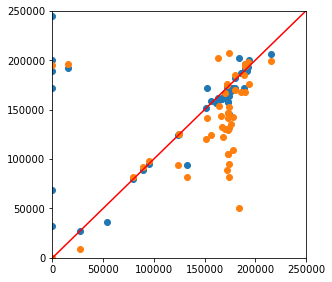

In [142]:
# plotting data availability
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2,2,1)

ax1.scatter(combined_distance['Distance_opr'], combined_distance['dist_spd'])
ax1.scatter(combined_distance['Distance_opr'], combined_distance['Distance_GPS'])
ax1.plot( [0,250000],[0,250000], 'r')
# ax1.xaxis_date()
# ax1.set_xlim(PartnerData['eday'].min(), PartnerData['eday'].max())
ax1.set_ylim(0, 250000)
ax1.set_xlim(0, 250000)
# ax1.yaxis.set_ticks(np.arange(1.25, len(PartnerData['VehicleId'].unique())+1))
# ax1.set_yticklabels(vehlist)
# fig.autofmt_xdate()

from above graph, it can be concluded that the coordinates reported from the data logger are not accurate enough/ or there are many missing data. The computed speed/distance data is a better quality

# optional - if the number of vehicle with different trip start and end dates is not zero

In [6]:
PartnerData[PartnerData['sday'] <> PartnerData['eday']]

TripId                               Owner VehicleId  Frequency  \
86   2016-10-13  Netherlands, Rotterdam, Operator 1  14-BGX-9          1   
134  2016-10-31  Netherlands, Rotterdam, Operator 1  32-BFJ-6          1   
142  2016-11-11  Netherlands, Rotterdam, Operator 1  32-BFJ-6          1   
160  2016-09-23  Netherlands, Rotterdam, Operator 1  46-BHB-2          1   

     Aggregation  Distance  StateOfChargeStart  StateOfChargeEnd  \
86             1   47970.0                99.0              62.0   
134            1   44620.0               100.0              63.0   
142            1   47865.0               100.0              56.0   
160            1   58130.0                99.0              52.0   

     StateOfChargeMax  StateOfChargeMin  StateOfChargeUp  StateOfChargeDown  \
86               99.0              62.0             16.0              -53.0   
134             100.0              63.0             20.0              -57.0   
142             100.0              56.0             20.0              -64.0   
160              99.0              52.0             15.0              -62.0   

              StartTime             EndTime  Duration  \
86  2016-10-12 23:18:33 2016-10-13 13:16:10     50257   
134 2016-10-30 23:00:00 2016-10-31 16:34:13     63253   
142 2016-11-10 23:00:04 2016-11-11 15:31:19     59475   
160 2016-09-22 23:41:50 2016-09-23 13:58:49     51419   

                                                Extras        sday  \
86   {u'DistanceGps': {u'_v': 0.0, u'_t': u'MongoDB...  2016-10-12   
134  {u'DistanceGps': {u'_v': 45164.871694, u'_t': ...  2016-10-30   
142  {u'DistanceGps': {u'_v': 10440.4284124, u'_t':...  2016-11-10   
160  {u'DistanceGps': {u'_v': 57750.9007865, u'_t':...  2016-09-22   

           eday  numofdays  VID  
86   2016-10-13         34    1  
134  2016-10-31         31    2  
142  2016-11-11         31    2  
160  2016-09-23         33    4

# NOTE: Plotting of data availability is based on the "endtime" record

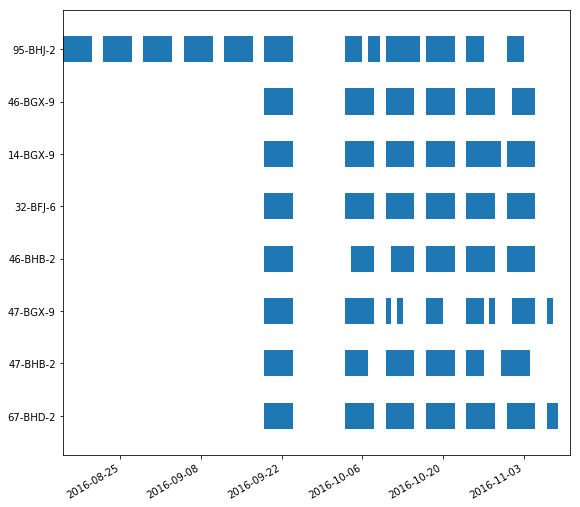

In [12]:
# plotting data availability
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(2,2,1)
vehlist = []
for i in PartnerData['VehicleId'].unique():
    datelist = []
    selVehData = PartnerData[PartnerData['VehicleId']==i]
    curID = selVehData['VID'].iloc[0]
    sdate = selVehData['eday'].min()
    edate = selVehData['eday'].max()
    diffdate = edate - sdate
    dateswitch = 0
    curdate = sdate
    for j in range(0, int(diffdate.days)):
        predate = curdate                          #previous date
        curdate = curdate + dt.timedelta(days=1)     #current date
        if any(selVehData['eday'] == curdate) and dateswitch == 1:
            sdate = curdate
            dateswitch = 0
        if (not any(selVehData['eday'] == curdate)) and dateswitch == 0:   #if current date is not available, call plotting
            #pltmain(sdate, predate)
            datelist.append((mpl.dates.date2num(sdate), mpl.dates.date2num(curdate)-mpl.dates.date2num(sdate)))
            dateswitch = 1
    ax1.broken_barh(datelist, (curID,0.5))
    vehlist = [i] + vehlist
ax1.xaxis_date()
ax1.set_xlim(PartnerData['eday'].min(), PartnerData['eday'].max())
ax1.set_ylim(0.5, len(PartnerData['VehicleId'].unique())+1)
ax1.yaxis.set_ticks(np.arange(1.25, len(PartnerData['VehicleId'].unique())+1))
ax1.set_yticklabels(vehlist)
fig.autofmt_xdate()

# plotting of total distance per day

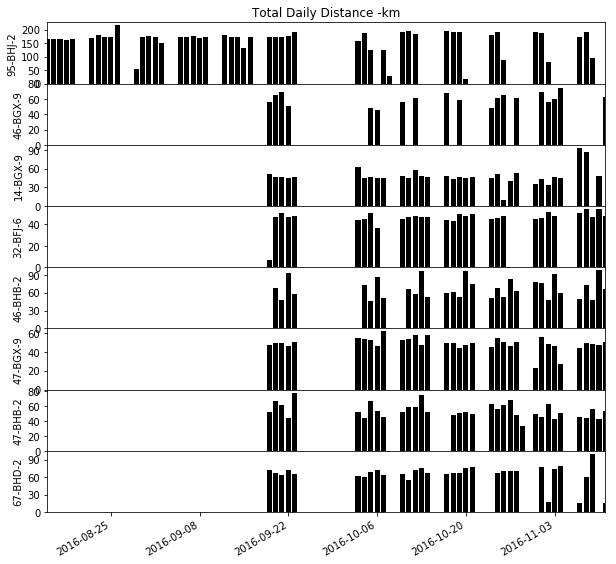

In [13]:
fig2 = pl.figure(figsize=(10, 10))
fig2.subplots_adjust(hspace=0.0)
# pl.subplots_adjust(hspace=0.1)
number_of_subplots=len(PartnerData['VehicleId'].unique())

for i,v in enumerate(xrange(number_of_subplots)):
    vehid = PartnerData['VehicleId'].unique()[i]
    selVehData2 = PartnerData[PartnerData['VehicleId']==vehid]

    sdate2 = selVehData2['eday'].min()
    edate2 = selVehData2['eday'].max()

    delta2 = edate2-sdate2
    
    v = v+1
    ax2 = fig2.add_subplot(number_of_subplots,1,v)
    ax2.bar(mpl.dates.date2num(selVehData2['eday']), selVehData2['Distance']/1000, color='black')

    ax2.xaxis_date()
    ax2.set_xlim(PartnerData['eday'].min(), PartnerData['eday'].max())
    ax2.set_ylabel(vehid)
    if i == 0:
        ax2.set_title("Total Daily Distance -km")
    maxdis = max(selVehData2['Distance']/1000)
    ax2.set_yticks(range(0,int(maxdis*1.1), int(math.ceil((maxdis*1.1/5)/10)*10)))
    
fig2.autofmt_xdate()


# speed profiles

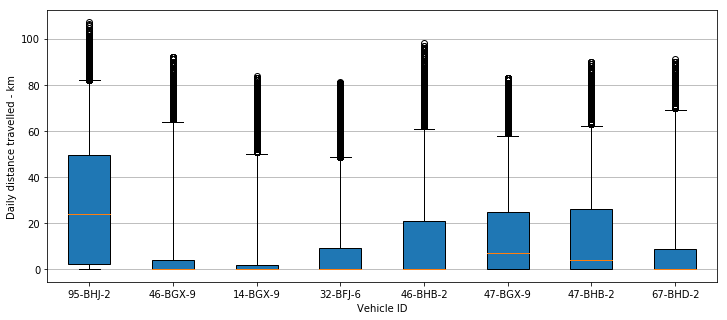

In [9]:
# box plot for distance statistics

fig3 = plt.figure(figsize=(12, 5))
ax3 = fig3.add_subplot(1,1,1)
# # Random test data
# np.random.seed(123)
# all_data = [np.random.normal(0, std, 100) for std in range(1, 4)]

lsdata = []
lsveh = []
boxplotdata = []
for i in Det_data['vid'].unique():
    lsveh.append(i)
    currdata = np.array(Det_data[Det_data['vid']==i]['spd'])
    boxplotdata.append(currdata)

boxplotdata = np.array(boxplotdata)
# boxplotdata['VehicleId'] = PartnerData['VehicleId']

# rectangular box plot
ax3.boxplot(boxplotdata,
            vert=True,   # vertical box aligmnent
            patch_artist=True, 
            whis=[5, 95])


# adding horizontal grid lines
ax3.yaxis.grid(True)
ax3.set_xticks([y+1 for y in range(len(Det_data['vid'].unique()))], )
ax3.set_xlabel('Vehicle ID')
ax3.set_ylabel('Daily distance travelled - km')

# add x-tick labels
plt.setp(ax3, xticks=[y+1 for y in range(len(Det_data['vid'].unique()))],
         xticklabels=lsveh)

# plt.show()

# some statistics of daily distance for each of the vehicle

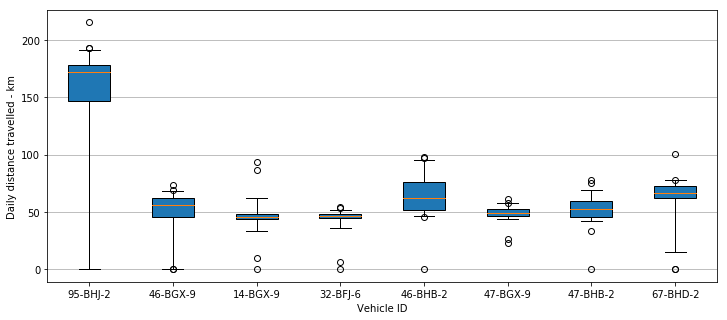

In [14]:
# box plot for distance statistics

fig3 = plt.figure(figsize=(12, 5))
ax3 = fig3.add_subplot(1,1,1)
# # Random test data
# np.random.seed(123)
# all_data = [np.random.normal(0, std, 100) for std in range(1, 4)]

lsdata = []
lsveh = []
boxplotdata = []
for i in PartnerData['VehicleId'].unique():
    lsveh.append(i)
    currdata = np.array(PartnerData[PartnerData['VehicleId']==i]['Distance']/1000)
    boxplotdata.append(currdata)

boxplotdata = np.array(boxplotdata)
# boxplotdata['VehicleId'] = PartnerData['VehicleId']

# rectangular box plot
ax3.boxplot(boxplotdata,
            vert=True,   # vertical box aligmnent
            patch_artist=True, 
            whis=[5, 95])


# adding horizontal grid lines
ax3.yaxis.grid(True)
ax3.set_xticks([y+1 for y in range(len(PartnerData['VehicleId'].unique()))], )
ax3.set_xlabel('Vehicle ID')
ax3.set_ylabel('Daily distance travelled - km')

# add x-tick labels
plt.setp(ax3, xticks=[y+1 for y in range(len(PartnerData['VehicleId'].unique()))],
         xticklabels=lsveh)

# plt.show()

# looking at speed profile; 

In [155]:
cursor2 = coll.find({"Owner": curpartner})

DetailedData = []

for record in cursor2:
    veh_id = record['VehicleId']
    for datapoint in record['DataPoints']:
        eachdatapoint = {
            "timestamp": datapoint.get('ts'),
            "lat": datapoint.get('lat'),
            "lon": datapoint.get('lon'),
            "spd": datapoint.get('s'),
            "soc": datapoint.get('soc'),
            'vid': veh_id
        }
        DetailedData.append(eachdatapoint)
gc.collect()

DetailedData = pd.DataFrame(DetailedData).sort_values(by = 'timestamp')
DetailedData = DetailedData.reset_index(drop=True)
DetailedData['date'] = [x.date() for x in DetailedData['timestamp']]
DetailedData['time'] = [x.time() for x in DetailedData['timestamp']]

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7


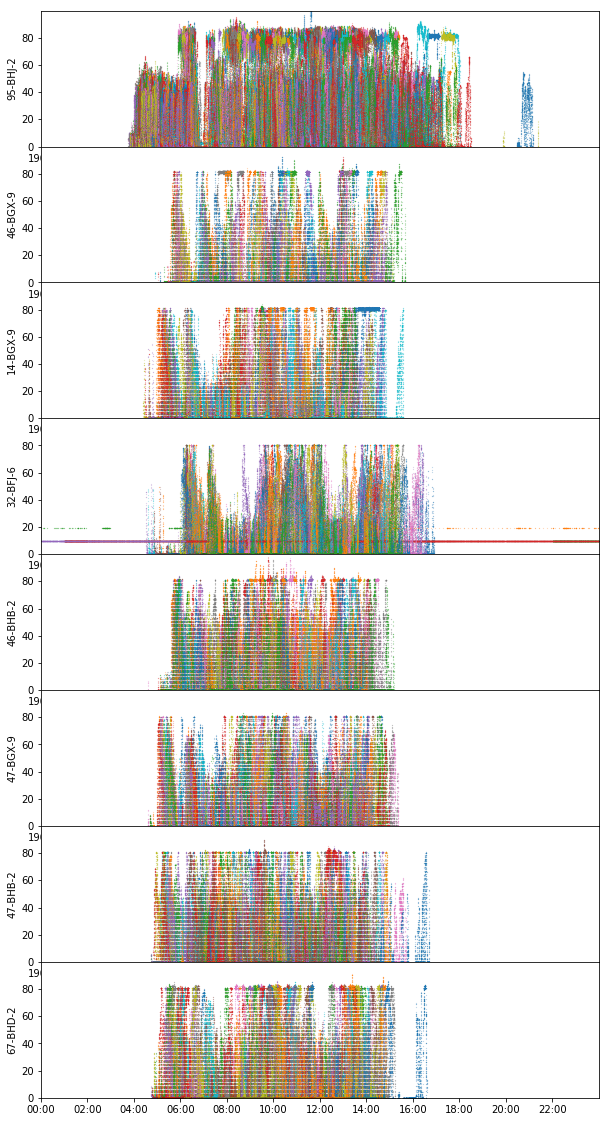

In [156]:

# DetailedData['time'] = [x.time().strftime("%H:%M:%S") for x in DetailedData['timestamp']]
# DetailedData['date'] = [x.date() for x in DetailedData['timestamp']]

fig5 = pl.figure(figsize=(10, 20))
fig5.subplots_adjust(hspace=0.0)
# pl.subplots_adjust(hspace=0.1)
number_of_subplots=len(PartnerData['VehicleId'].unique())

for i,v in enumerate(xrange(number_of_subplots)):
    print i,v
    vehid5 = PartnerData['VehicleId'].unique()[i]
    selVehData5 = DetailedData[DetailedData['vid']==vehid5]
#     datelist = [dt.datetime.strptime(str(x), "%H:%M:%S") for x in seldate['time']]
    datemin = dt.datetime.strptime("1900-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
    datemax = dt.datetime.strptime("1900-01-02 00:00:00", "%Y-%m-%d %H:%M:%S")
    v = v+1
    ax5 = fig5.add_subplot(number_of_subplots,1,v)
    for j in selVehData5['date'].unique():
        seldate = selVehData5[selVehData5['date'] ==j]
        ax5.scatter(mpl.dates.date2num([dt.datetime.strptime(x.strftime("%H:%M:%S"), "%H:%M:%S") for x in seldate['time']]), 
                 seldate['spd'], s=0.01)
    ax5.set_ylabel(vehid5)
    ax5.set_ylim(0, 100)
    ax5.set_yticks(range(0,100,20))
    ax5.set_xlim(datemin,datemax)
    ax5.set_xticks(np.arange(datemin, datemax, (datemax - datemin)/12))

xfmt = mpl.dates.DateFormatter('%H:%M')
ax5.xaxis.set_major_formatter(xfmt)

from above graph, it can be seen that the speed reading are most of the time very accurate. however, there are a few errors which need to be corrected.

# for a single day speed profile:

2016-11-09


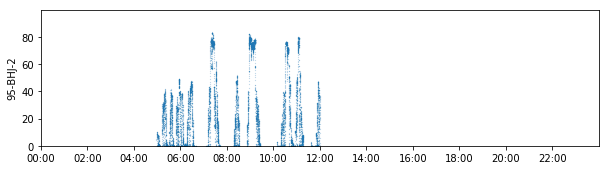

In [152]:
fig5 = pl.figure(figsize=(10, 20))
fig5.subplots_adjust(hspace=0.0)
# pl.subplots_adjust(hspace=0.1)
number_of_subplots=len(PartnerData['VehicleId'].unique())
i=0
v=0
vehid5 = PartnerData['VehicleId'].unique()[i]
selVehData5 = DetailedData[DetailedData['vid']==vehid5]
#     datelist = [dt.datetime.strptime(str(x), "%H:%M:%S") for x in seldate['time']]
datemin = dt.datetime.strptime("1900-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
datemax = dt.datetime.strptime("1900-01-02 00:00:00", "%Y-%m-%d %H:%M:%S")
v = v+1
ax5 = fig5.add_subplot(number_of_subplots,1,v)
print j
seldate = selVehData5[selVehData5['date'] ==j]
ax5.scatter(mpl.dates.date2num([dt.datetime.strptime(x.strftime("%H:%M:%S"), "%H:%M:%S") for x in seldate['time']]), 
         seldate['spd'], s=0.01)
ax5.set_ylabel(vehid5)
ax5.set_ylim(0, 100)
ax5.set_yticks(range(0,100,20))
ax5.set_xlim(datemin,datemax)
ax5.set_xticks(np.arange(datemin, datemax, (datemax - datemin)/12))

xfmt = mpl.dates.DateFormatter('%H:%M')
ax5.xaxis.set_major_formatter(xfmt)

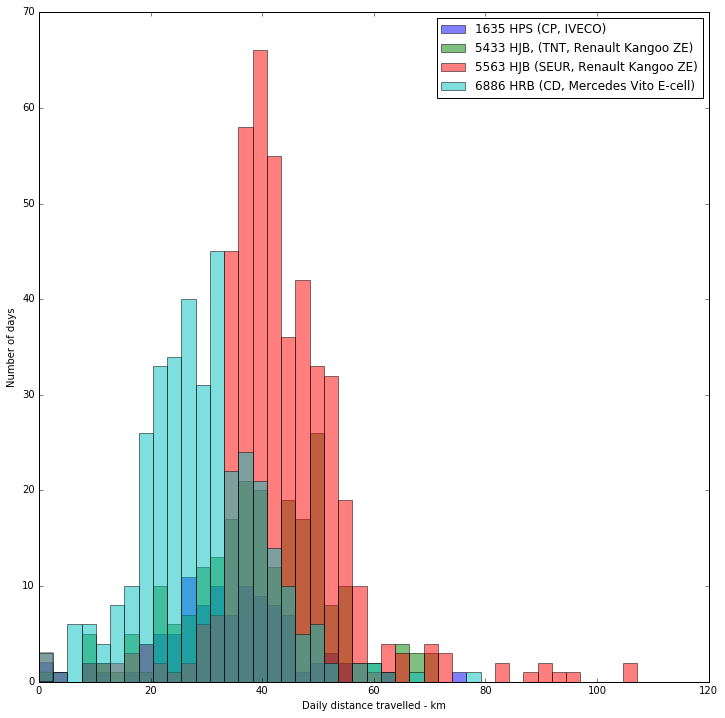

In [114]:
# histogram 

fig4 = plt.figure(figsize=(12, 12))
ax4 = fig4.add_subplot(1,1,1)

bins = np.linspace(0,120,48)

# rectangular box plot
for i in range(len(boxplotdata)):
    ax4.hist(boxplotdata[i], bins, alpha=0.5, label = lsveh[i])
ax4.legend(loc='upper right')
    
# adding horizontal grid lines
# ax3.yaxis.grid(True)
# ax3.set_xticks([y+1 for y in range(len(PartnerData['VehicleId'].unique()))], )
ax4.set_ylabel('Number of days')
ax4.set_xlabel('Daily distance travelled - km')


# now look at telematics data (seconds data)

In [115]:
#import detailed data and create a dataframe
# cursor2 = coll.find(
#         {"$and": [
#                  {"Owner": curpartner},
#                  {"Distance": {"$gt": 0}}
#                 ]
#         })

cursor2 = coll.find({"Owner": curpartner})

DetailedData = []

for record in cursor2:
    veh_id = record['VehicleId']
    for datapoint in record['DataPoints']:
        eachdatapoint = {
            "timestamp": datapoint.get('ts'),
            "lat": datapoint.get('lat'),
            "lon": datapoint.get('lon'),
            "alt": datapoint.get('alt'),
            "speed": datapoint.get('s'),
            "soc": datapoint.get('soc'),
            "range": datapoint.get('r'),
            "batterytemp": datapoint.get('tb'),
            "cabtemp": datapoint.get('ti'),
            "outsidetemp": datapoint.get('to'),
            "throttle": datapoint.get('thr'),
            "ignition": datapoint.get('i'),
            'VehID': veh_id
        }
        DetailedData.append(eachdatapoint)
gc.collect()

DetailedData = pd.DataFrame(DetailedData).sort_values(by = 'timestamp')
DetailedData = DetailedData.reset_index(drop=True)

# plotting of the state of charge status over the periods

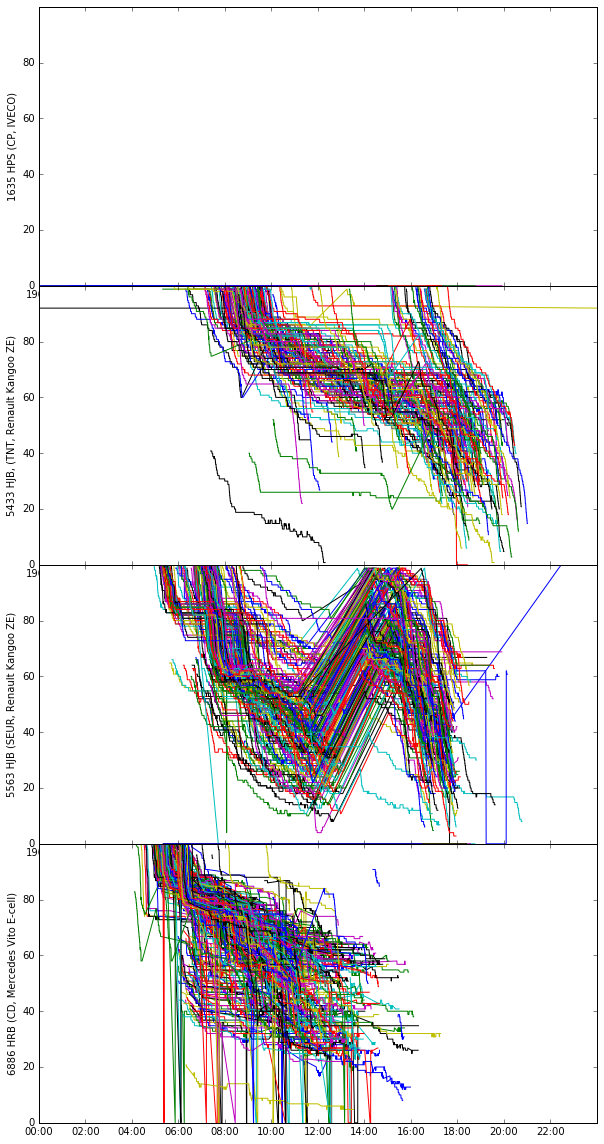

In [121]:

DetailedData['time'] = [x.time().strftime("%H:%M:%S") for x in DetailedData['timestamp']]
DetailedData['date'] = [x.date() for x in DetailedData['timestamp']]

fig5 = pl.figure(figsize=(10, 20))
fig5.subplots_adjust(hspace=0.0)
# pl.subplots_adjust(hspace=0.1)
number_of_subplots=len(PartnerData['VehicleId'].unique())

for i,v in enumerate(xrange(number_of_subplots)):
    vehid5 = PartnerData['VehicleId'].unique()[i]
    selVehData5 = DetailedData[DetailedData['VehID']==vehid5]
#     datelist = [dt.datetime.strptime(str(x), "%H:%M:%S") for x in seldate['time']]
    datemin = dt.datetime.strptime("1900-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
    datemax = dt.datetime.strptime("1900-01-02 00:00:00", "%Y-%m-%d %H:%M:%S")
    v = v+1
    ax5 = fig5.add_subplot(number_of_subplots,1,v)
    for j in selVehData5['date'].unique():
        seldate = selVehData5[selVehData5['date'] ==j]
        ax5.plot(mpl.dates.date2num([dt.datetime.strptime(x, "%H:%M:%S") for x in seldate['time']]), 
                 seldate['soc'])
    ax5.set_ylabel(vehid5)
    ax5.set_ylim(0, 100)
    ax5.set_yticks(range(0,100,20))
    ax5.set_xlim(datemin,datemax)
    ax5.set_xticks(np.arange(datemin, datemax, (datemax - datemin)/12))

xfmt = mpl.dates.dateFormatter('%H:%M')
ax5.xaxis.set_major_formatter(xfmt)
    
# fig5.autofmt_xdate()


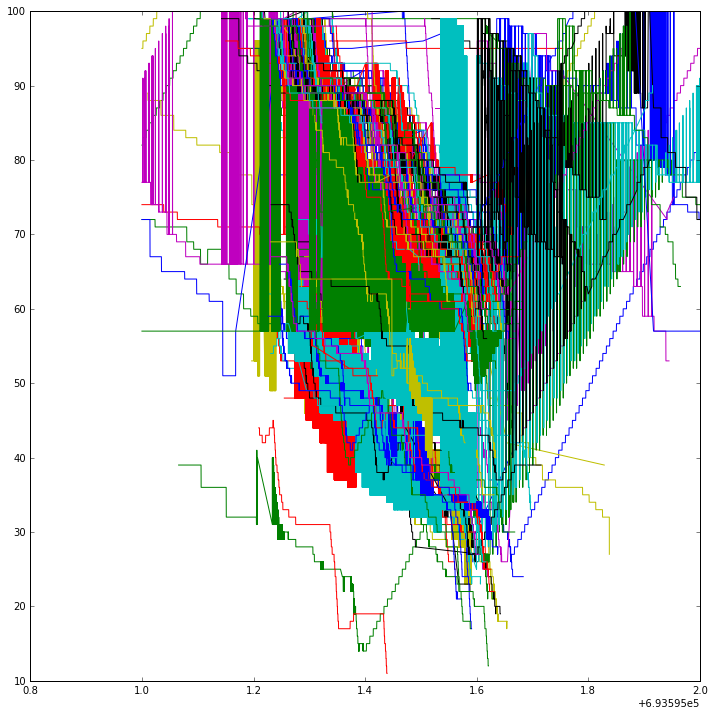

In [67]:
fig5 = plt.figure(figsize=(12, 12))
ax5 = fig5.add_subplot(1,1,1)
selVehData5 = DetailedData[DetailedData['VehID']=='GINAF 001']
for j in selVehData5['date'].unique():
    seldate = selVehData5[selVehData5['date'] ==j]
    ax5.plot(mpl.dates.date2num([dt.datetime.strptime(str(x), "%H:%M:%S") for x in seldate['time']]), 
             seldate['soc'])


In [117]:
DetailedData

VehID    alt batterytemp cabtemp  \
0                     1635 HPS (CP, IVECO)  618.0        None    None   
1                     1635 HPS (CP, IVECO)  606.0        None    None   
2                     1635 HPS (CP, IVECO)  583.0        None    None   
3                     1635 HPS (CP, IVECO)  581.0        None    None   
4                     1635 HPS (CP, IVECO)  574.0        None    None   
5                     1635 HPS (CP, IVECO)  574.0        None    None   
6                     1635 HPS (CP, IVECO)  574.0        None    None   
7                     1635 HPS (CP, IVECO)  583.0        None    None   
8                     1635 HPS (CP, IVECO)  597.0        None    None   
9                     1635 HPS (CP, IVECO)  615.0        None    None   
10                    1635 HPS (CP, IVECO)  622.0        None    None   
11                    1635 HPS (CP, IVECO)  614.0        None    None   
12                    1635 HPS (CP, IVECO)  616.0        None    None   
13                    1635 HPS (CP, IVECO)  616.0        None    None   
14                    1635 HPS (CP, IVECO)  619.0        None    None   
15                    1635 HPS (CP, IVECO)  622.0        None    None   
16                    1635 HPS (CP, IVECO)  622.0        None    None   
17                    1635 HPS (CP, IVECO)  633.0        None    None   
18                    1635 HPS (CP, IVECO)  630.0        None    None   
19                    1635 HPS (CP, IVECO)  611.0        None    None   
20                    1635 HPS (CP, IVECO)  612.0        None    None   
21                    1635 HPS (CP, IVECO)  616.0        None    None   
22                    1635 HPS (CP, IVECO)  632.0        None    None   
23                    1635 HPS (CP, IVECO)  639.0        None    None   
24                    1635 HPS (CP, IVECO)  645.0        None    None   
25                    1635 HPS (CP, IVECO)  644.0        None    None   
26                    1635 HPS (CP, IVECO)  625.0        None    None   
27                    1635 HPS (CP, IVECO)  660.0        None    None   
28                    1635 HPS (CP, IVECO)  685.0        None    None   
29                    1635 HPS (CP, IVECO)  676.0        None    None   
...                                    ...    ...         ...     ...   
885204  5433 HJB, (TNT, Renault Kangoo ZE)    0.0        None    None   
885205  5433 HJB, (TNT, Renault Kangoo ZE)    0.0        None    None   
885206  5433 HJB, (TNT, Renault Kangoo ZE)    0.0        None    None   
885207  5433 HJB, (TNT, Renault Kangoo ZE)    0.0        None    None   
885208  5433 HJB, (TNT, Renault Kangoo ZE)    0.0        None    None   
885209  5433 HJB, (TNT, Renault Kangoo ZE)    0.0        None    None   
885210  5433 HJB, (TNT, Renault Kangoo ZE)  570.0        None    None   
885211  5433 HJB, (TNT, Renault Kangoo ZE)  572.0        None    None   
885212  5433 HJB, (TNT, Renault Kangoo ZE)  578.0        None    None   
885213  5433 HJB, (TNT, Renault Kangoo ZE)  570.0        None    None   
885214  5433 HJB, (TNT, Renault Kangoo ZE)  569.0        None    None   
885215  5433 HJB, (TNT, Renault Kangoo ZE)  573.0        None    None   
885216  5433 HJB, (TNT, Renault Kangoo ZE)  581.0        None    None   
885217  5433 HJB, (TNT, Renault Kangoo ZE)  566.0        None    None   
885218  5433 HJB, (TNT, Renault Kangoo ZE)  564.0        None    None   
885219  5433 HJB, (TNT, Renault Kangoo ZE)  579.0        None    None   
885220  5433 HJB, (TNT, Renault Kangoo ZE)  599.0        None    None   
885221  5433 HJB, (TNT, Renault Kangoo ZE)  605.0        None    None   
885222  5433 HJB, (TNT, Renault Kangoo ZE)  609.0        None    None   
885223  5433 HJB, (TNT, Renault Kangoo ZE)  606.0        None    None   
885224  5433 HJB, (TNT, Renault Kangoo ZE)  609.0        None    None   
885225  5433 HJB, (TNT, Renault Kangoo ZE)  616.0        None    None   
885226  5433 HJB, (TNT, Renault Kangoo ZE)  611.0        None    None   
885227  5433 HJB, (TNT

In [106]:
PartnerData[PartnerData['VehicleId']==i]['Distance']

0         77.548528
1       4134.428466
2       2451.548912
3        175.761655
4       1623.822127
5        181.301679
6       3103.328227
7       6613.021467
8        289.922181
9       1841.947230
10      1468.276913
11      1190.514773
12      1666.458008
13      1240.781769
14      1616.809155
15      2935.666735
16      5957.876422
17        86.773493
18      4201.864847
19      1110.998327
20      2188.124006
21        30.395590
22      9707.510010
23      7742.228408
24       794.228783
25      5417.574543
26       478.351729
27      1314.895143
28      1305.944977
29      1920.426044
           ...     
244       56.558139
245     4031.628294
246      474.484942
247     3251.501928
248     2390.084180
249      280.184760
250     2960.592351
251      837.294178
252     1597.554870
253      265.036937
254     2859.141802
255     3939.735004
256     5500.903857
257       42.072780
258     2296.128651
259      986.838663
260     2330.788146
261    10711.516285
262     3675.946191


# need to check whether there are multiple trips from a same vehicle in a single day

In [ ]:
sum(PartnerData['sday'] <> PartnerData['eday'])

In [ ]:
PartnerData.head(5)

In [ ]:
# plotting data availability
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(2,2,1)

for i in PartnerData['VehicleId'].unique():
    datelist = []
    selVehData = PartnerData[PartnerData['VehicleId']==i]
    curID = selVehData['VID'].iloc[0]
    sdate = selVehData['TripId'].min()
    edate = selVehData['TripId'].max()
    diffdate = edate - sdate
    dateswitch = 0
    curdate = sdate
    for j in range(0, int(diffdate.days)):
        predate = curdate                          #previous date
        curdate = curdate + dt.timedelta(days=1)     #current date
        if any(selVehData['TripId'] == curdate) and dateswitch == 1:
            sdate = curdate
            dateswitch = 0
        if (not any(selVehData['TripId'] == curdate)) and dateswitch == 0:   #if current date is not available, call plotting
            #pltmain(sdate, predate)
            datelist.append((mpl.dates.date2num(sdate), mpl.dates.date2num(curdate)-mpl.dates.date2num(sdate)))
            dateswitch = 1
    ax1.broken_barh(datelist, (curID,0.5))
ax1.xaxis_date()
ax1.set_xlim(PartnerData['TripId'].min(), PartnerData['TripId'].max())

In [ ]:
PartnerData.head(5)

In [ ]:
mpl.dates.date2num(dt.datetime.now())

In [ ]:
curdate = sdate + dt.timedelta(days=1)
print curdate
any(selVehData['TripId'] == curdate)

In [ ]:
#import datetime
#tt = datetime.datetime.strptime(PartnerData['TripId'], "%Y-%m-%d")
PartnerData['TripId'] = pd.to_datetime(PartnerData['TripId'])
#tt.apply(lambda x: x.strftime('%Y-%m-%d'))

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(2,2,1)
#for i in range(0, PartnerData['TripId'].count()):
ax1.broken_barh(PartnerData['TripId'], PartnerData['VID'])

In [ ]:
cursor = coll.find(
        {"$and": [
                 {"Owner": "United Kingdom, London, UPS"},
                 {"Distance": {"$gt": 0}}
                ]
        })
UPSLondon = pd.DataFrame(list(cursor))

In [ ]:
cursor2 = coll.aggregate([
    {"$match": {"$and": [
                        {"Owner": vehlist.iloc[0,1]}, 
                        {"Distance": {"$gt": 0}}
                ]}
    },
    {"$group": {"_id": "$VehicleId", "AverageDistance": {"$avg": "$Distance"}}}
])

In [ ]:
print PartnerData.head(n=10)
PartnerData.iloc[0,5]
len(PartnerData['VehicleId'].unique())

In [ ]:
cursor1 = coll.aggregate([
        {"$group": {"_id": "$Owner", "NumberOfTrips": {"$sum": 1}}}
    ])
array = list(cursor1)
vehlist = pd.DataFrame(array)    #list of operation partners
curpartner = vehlist.iloc[7,1]   #current partner can set up a loop  ********************
print curpartner